# Dog Memorizer GAN
## DISCLAIMER: This may not be a valid comp solution
In this kernel we attempt to create a new kind of semi-supervised GAN. (Typical GAN design is presented in Nanashi's great tutorial [here][4]). Instead of having the Generator and Discriminator learn at the same time, we will first train the Discriminator to memorize all the training images. Next the Discriminator will teach the images to the Generator. We give the Generator poor memory (with a bottleneck) in hopes that it will learn to generalize. For our Kaggle submission, we will ask this Generator to output a mixture of (the generalized) images it has learned. Since the images are stored in a conv net, we hope to get a generalized conceptual mixture (versus a pixel blend). (This kernel is inspired by the tutorial [here][1] and by my previous kernels [here][2] and [here][3]).

![image](http://playagricola.com/Kaggle/gan7419.png)

A GAN consists of a Generator and Discriminator. After being trained, a Generator is a robot artist that draws dog images. During training the Discriminator teaches the Generator how to draw a dog. (And typically the G teaches the D to disguish real from fake dogs). The Generator never sees any images of dogs. Instead it continually attempts to draw a dog and is coached by the Discriminator. In this kernel, the **Memorizer** Generator is coached to memorize images from the training set. (We hope generalization arises from poor memory). In contrast, a **Generalizing** Generator is coached to generalize images!

# Load and Crop Images

[1]: https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3
[2]: https://www.kaggle.com/cdeotte/dog-autoencoder
[3]: https://www.kaggle.com/cdeotte/supervised-generative-dog-net
[4]: https://www.kaggle.com/jesucristo/gan-introduction

In [1]:
import pandas as pd

In [2]:
# initialize list of lists
path1 = '../input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images_manufacturer_val.txt'
path2 = '../input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images_manufacturer_test.txt'
path3 = '../input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images_manufacturer_train.txt'
data = []
with open(path1) as f:
    lines = f.readlines()
    for line in lines:
        name = line.split()[0]+'.jpg'
        manu = ' '.join(line.split()[1:])
        data.append([name, manu])
with open(path2) as f:
    lines = f.readlines()
    for line in lines:
        name = line.split()[0]+'.jpg'
        manu = ' '.join(line.split()[1:])
        data.append([name, manu])
with open(path3) as f:
    lines = f.readlines()
    for line in lines:
        name = line.split()[0]+'.jpg'
        manu = ' '.join(line.split()[1:])
        data.append([name, manu])

# Create the pandas DataFrame
labels = pd.DataFrame(data, columns=['filename', 'Manufacturer'])
labels

filename Manufacturer
0     0481847.jpg       Boeing
1     0810608.jpg       Boeing
2     1514481.jpg       Boeing
3     0887066.jpg       Boeing
4     1318819.jpg       Boeing
5     0624128.jpg       Boeing
6     0602177.jpg       Boeing
7     1148180.jpg       Boeing
8     1346004.jpg       Boeing
9     1288661.jpg       Boeing
10    0760910.jpg       Boeing
11    0113201.jpg       Boeing
12    0923884.jpg       Boeing
13    0987261.jpg       Boeing
14    0536511.jpg       Boeing
15    0732667.jpg       Boeing
16    0901498.jpg       Boeing
17    0631897.jpg       Boeing
18    1193587.jpg       Boeing
19    0198101.jpg       Boeing
20    1017179.jpg       Boeing
21    1068565.jpg       Boeing
22    0063435.jpg       Boeing
23    0732410.jpg       Boeing
24    0536721.jpg       Boeing
25    1518652.jpg       Boeing
26    1009831.jpg       Boeing
27    0062781.jpg       Boeing
28    0458781.jpg       Boeing
29    1514484.jpg       Boeing
...           ...          ...
9970  1176914.jpg     Yakovlev
9971  0077513.jpg     Yakovlev
9972  1056902.jpg     Yakovlev
9973  0792373.jpg     Yakovlev
9974  1627581.jpg     Yakovlev
9975  1284223.jpg     Yakovlev
9976  1429966.jpg     Yakovlev
9977  1826524.jpg     Yakovlev
9978  0490185.jpg     Yakovlev
9979  0606123.jpg     Yakovlev
9980  0749478.jpg     Yakovlev
9981  0066408.jpg     Yakovlev
9982  0901509.jpg     Yakovlev
9983  1501838.jpg     Yakovlev
9984  0730106.jpg     Yakovlev
9985  1611239.jpg     Yakovlev
9986  0504825.jpg     Yakovlev
9987  1581695.jpg     Yakovlev
9988  0198777.jpg     Yakovlev
9989  0819685.jpg     Yakovlev
9990  1696014.jpg     Yakovlev
9991  0394095.jpg     Yakovlev
9992  1000013.jpg     Yakovlev
9993  1544139.jpg     Yakovlev
9994  0522968.jpg     Yakovlev
9995  1577680.jpg     Yakovlev
9996  1826676.jpg     Yakovlev
9997  0472681.jpg     Yakovlev
9998  1597829.jpg     Yakovlev
9999  0197891.jpg     Yakovlev

[10000 rows x 2 columns]

In [3]:
print(labels.loc[labels['filename'] == "2042721.jpg"].Manufacturer.values)
print(len(labels.loc[labels['filename'] == "wrong"].Manufacturer.values))

['Supermarine']
0


In [4]:
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

ROOT = '../input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/'
IMAGES = os.listdir(ROOT + 'images')

label_dict = {}
image_count = {}
k = 0
for i in IMAGES:
    if labels.loc[labels['filename'] == i].Manufacturer.values[0] not in label_dict:
        label_dict[labels.loc[labels['filename'] == i].Manufacturer.values[0]] = k
        image_count[labels.loc[labels['filename'] == i].Manufacturer.values[0]] = 0
        k += 1
    image_count[labels.loc[labels['filename'] == i].Manufacturer.values[0]] += 1
# label_dict
image_count

{'Supermarine': 100,
 'Embraer': 700,
 'Airbus': 1300,
 'Boeing': 2200,
 'ATR': 200,
 'Gulfstream Aerospace': 200,
 'Cessna': 400,
 'British Aerospace': 400,
 'Saab': 200,
 'de Havilland': 500,
 'Lockheed Corporation': 200,
 'Beechcraft': 200,
 'Douglas Aircraft Company': 400,
 'Ilyushin': 100,
 'McDonnell Douglas': 700,
 'Panavia': 100,
 'Tupolev': 200,
 'Piper': 100,
 'Fairchild': 100,
 'Fokker': 300,
 'Canadair': 400,
 'Dassault Aviation': 200,
 'Eurofighter': 100,
 'Dornier': 100,
 'Yakovlev': 100,
 'Lockheed Martin': 100,
 'Cirrus Aircraft': 100,
 'Robin': 100,
 'Antonov': 100,
 'Bombardier Aerospace': 100}

In [5]:
len(label_dict.keys())

30

In [6]:
idxIn = [0 for i in range(30)]
imagesIn = [np.zeros((image_count[key],64,64,3)) for key in label_dict.keys()]

count = 0
# RANDOMLY CROP FULL IMAGES
for i in IMAGES:
    i_label = labels.loc[labels['filename'] == i].Manufacturer.values[0]
    img = Image.open(ROOT + 'images/' + i)
    w = img.size[0]
    h = img.size[1]
    sz = np.min((w,h))
    a=0; b=0
    if w<h: b = (h-sz)//2
    else: a = (w-sz)//2
    img = img.crop((0+a, 0+b, sz+a, sz+b))  
    img = img.resize((64,64), Image.ANTIALIAS)   
    label_count = label_dict[i_label]
    imagesIn[label_count][idxIn[label_count],:,:,:] = np.asarray(img)
    idxIn[label_count] += 1
    if (count %1000 == 0): print(count)
    count += 1

print(idxIn)
# print(namesIn)
# print(labelsIn)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
[100, 700, 1300, 2200, 200, 200, 400, 400, 200, 500, 200, 200, 400, 100, 700, 100, 200, 100, 100, 300, 400, 200, 100, 100, 100, 100, 100, 100, 100, 100]


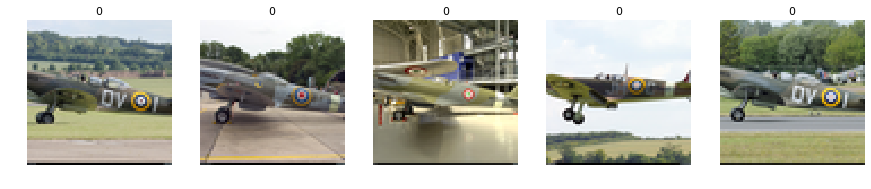

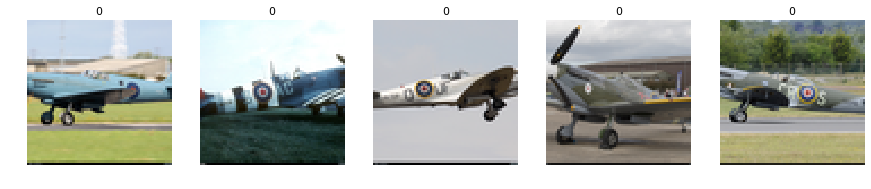

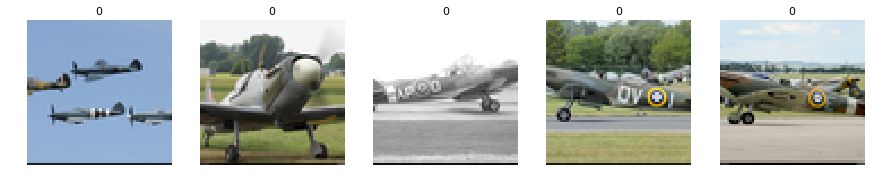

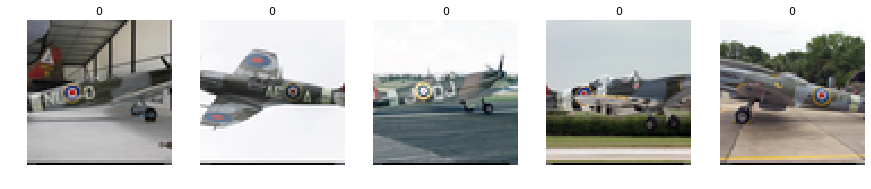

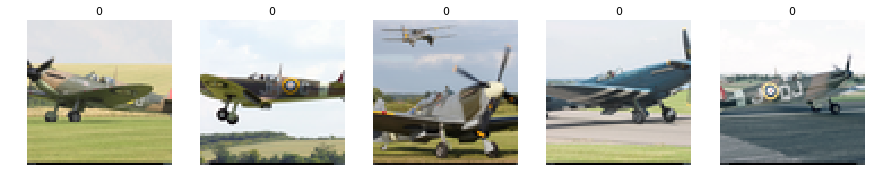

In [7]:
import random
# DISPLAY CROPPED IMAGES
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        rand2 = random.randint(0, 99)
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[0][rand2,:,:,:].astype('uint8') )
        plt.axis('off')
        plt.title(0,fontsize=11)
        plt.imshow(img)
    plt.show()

# Build Discriminator

In [8]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Reshape, Flatten, concatenate, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [9]:
discriminator = []
# BUILD DISCRIMINATIVE NETWORK
for man in label_dict.keys():
    plane = Input((12288,))
    planeName = Input((image_count[man],))
    x = Dense(12288, activation='sigmoid')(planeName) 
    x = Reshape((2,12288,1))(concatenate([plane, x]))
    x = Conv2D(1,(2,1),use_bias=False,name='conv')(x)
    discriminated = Flatten()(x)
    discriminator.append(Model([plane,planeName], discriminated))

# DISPLAY ARCHITECTURE
discriminator[0].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 12288)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12288)        1241088     input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 24576)        0           input_1[0][0]                    
                                                                 dense_1[0][0]                    
__________

In [10]:
for i in range(30): 
    discriminator[i].get_layer('conv').trainable = False
    discriminator[i].get_layer('conv').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
    discriminator[i].compile(optimizer='adam', loss='binary_crossentropy')
    print("-",end="")

------------------------------

# Train Discriminator
We will train the Discriminator to memorize the training images. (Typically you don't train the Discriminator ahead of time. The D learns as the G learns. But this GAN is special).

In [11]:
ic_list = [image_count[key] for key in label_dict.keys()]

for i in range(30):
    ic = ic_list[i]
    # TRAINING DATA
    train_y = (imagesIn[i][:ic,:,:,:]/255.0).reshape((-1,12288))
    train_X = np.zeros((ic,ic))
    for j in range(ic): train_X[j,j] = 1
    zeros = np.zeros((ic,12288))

    # TRAIN NETWORK
    lr = 0.5
    if (ic == 100): bs = 32
    elif (ic < 300): bs = 64
    else: bs = 128
    
    for k in range(5):
        annealer = LearningRateScheduler(lambda x: lr)
        h = discriminator[i].fit([zeros,train_X], train_y, epochs = 10, batch_size=bs, callbacks=[annealer], verbose=0)
        if h.history['loss'][-1]<0.533: lr = 0.1
    print("-", end="")

------------------------------

# Delete Training Images
Our Discriminator has memorized all the training images. We will now delete the training images. Our Generator will never see the training images. It will only be coached by the Discriminator. Below are examples of images that the Discriminator memorized.

In [12]:
del train_X, train_y, imagesIn

Discriminator Recalls from Memory Planes


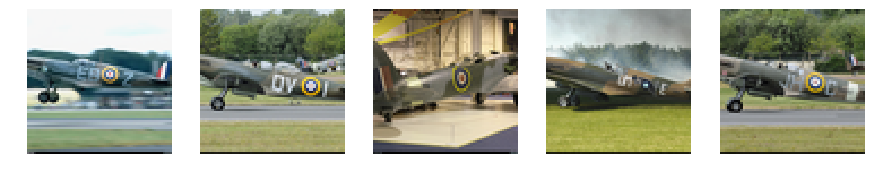

In [13]:
print('Discriminator Recalls from Memory Planes')    

plt.figure(figsize=(15,3))
for j in range(5):
    xx = np.zeros((100))
    xx[np.random.randint(100)] = 1
    plt.subplot(1,5,j+1)
    img = discriminator[0].predict([zeros[0,:].reshape((-1,12288)),xx.reshape((-1,100))]).reshape((-1,64,64,3))
    img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
    plt.axis('off')
    plt.imshow(img)
plt.show()

# Build Generator and GAN
We will purposely give our Generator a bottleneck in its memory. Using poor memory forces the Generator to learn a generalization of images and not memorize the images exactly.

In [14]:
# BUILD GENERATOR NETWORK

generator = []
for man in label_dict.keys():
    seed = Input((image_count[man],))
    x = Dense(2048, activation='elu')(seed)
    x = Reshape((8,8,32))(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), activation='linear', padding='same')(x)
    generated = Flatten()(x)
    generator.append(Model(seed, [generated,Reshape((image_count[man],))(seed)]))

# DISPLAY ARCHITECTURE
generator[0].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 2048)         206848      input_61[0][0]                   
__________________________________________________________________________________________________
reshape_31 (Reshape)            (None, 8, 8, 32)     0           dense_31[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 128)    36992       reshape_31[0][0]                 
__________________________________________________________________________________________________
up_samplin

In [15]:
# BUILD GENERATIVE ADVERSARIAL NETWORK
gan = []
for i in range(30):
    discriminator[i].trainable=False    
    gan_input = Input(shape=(ic_list[i],))
    x = generator[i](gan_input)
    gan_output = discriminator[i](x)

    # COMPILE GAN
    gan.append(Model(gan_input, gan_output))

    # DISPLAY ARCHITECTURE
gan[0].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_91 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
model_31 (Model)                [(None, 12288), (Non 336963      input_91[0][0]                   
__________________________________________________________________________________________________
model_1 (Model)                 (None, 12288)        1241090     model_31[1][0]                   
                                                                 model_31[1][1]                   
Total params: 1,578,053
Trainable params: 336,963
Non-trainable params: 1,241,090
__________________________________________________________________________________________________


In [16]:
for i in range(30):
    gan[i].get_layer('model_' + str(i+1)).get_layer('conv').set_weights([np.array([[[[-1 ]]],[[[255.]]]])])
    gan[i].compile(optimizer=Adam(5), loss='mean_squared_error')
    print("-", end='')
gan[0].summary()

------------------------------__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_91 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
model_31 (Model)                [(None, 12288), (Non 336963      input_91[0][0]                   
__________________________________________________________________________________________________
model_1 (Model)                 (None, 12288)        1241090     model_31[1][0]                   
                                                                 model_31[1][1]                   
Total params: 1,578,053
Trainable params: 336,963
Non-trainable params: 1,241,090
________________________________________________________________________________________________

# Discriminator Coaches Generator
In a typical GAN, the discriminator does not memorize the training images beforehand. Instead it learns to distinquish real images from fake images at the same time that the Generator learns to make fake images. In this GAN, we taught the Discriminator ahead of time and it will now teach the Generator.

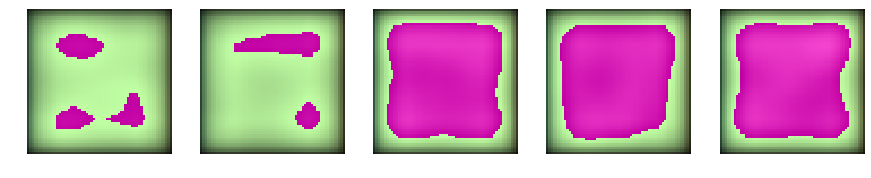

Epoch 1 /50 - loss = 14194.8441796875
Epoch 2 /50 - loss = 7794.3948046875
Epoch 3 /50 - loss = 3203.8021875
Epoch 4 /50 - loss = 1849.111962890625
Epoch 5 /50 - loss = 1282.1991162109375
Epoch 6 /50 - loss = 1082.383271484375
Epoch 7 /50 - loss = 822.261279296875
Epoch 8 /50 - loss = 570.00447265625
Epoch 9 /50 - loss = 418.67176147460935
Epoch 10 /50 - loss = 347.2887548828125


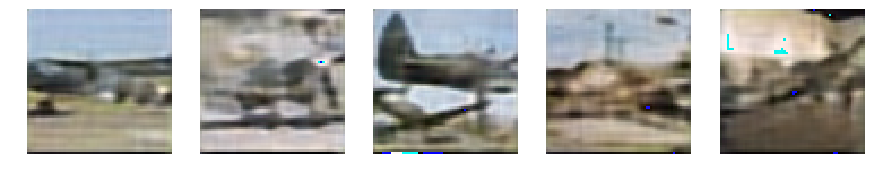

Epoch 11 /50 - loss = 311.7368151855469
Epoch 12 /50 - loss = 260.4087567138672
Epoch 13 /50 - loss = 244.06176513671875
Epoch 14 /50 - loss = 218.1900079345703
Epoch 15 /50 - loss = 191.58841796875
Epoch 16 /50 - loss = 180.02830078125
Epoch 17 /50 - loss = 167.23175476074218
Epoch 18 /50 - loss = 157.73375732421874
Epoch 19 /50 - loss = 147.672890625
Epoch 20 /50 - loss = 136.9977377319336


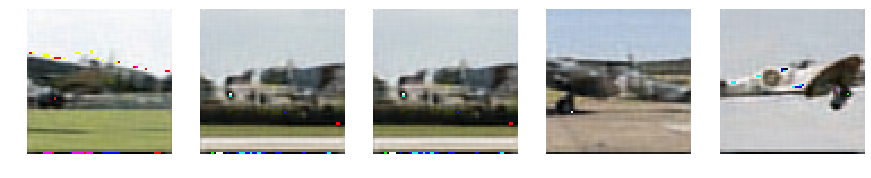

Epoch 21 /50 - loss = 151.00015625
Epoch 22 /50 - loss = 129.96076904296876
Epoch 23 /50 - loss = 116.76158813476563
Epoch 24 /50 - loss = 113.27225646972656
Epoch 25 /50 - loss = 108.12740234375
Epoch 26 /50 - loss = 100.95290161132813
Epoch 27 /50 - loss = 93.7250390625
Epoch 28 /50 - loss = 105.36520751953125
Epoch 29 /50 - loss = 86.42232238769532
Epoch 30 /50 - loss = 85.21805938720703


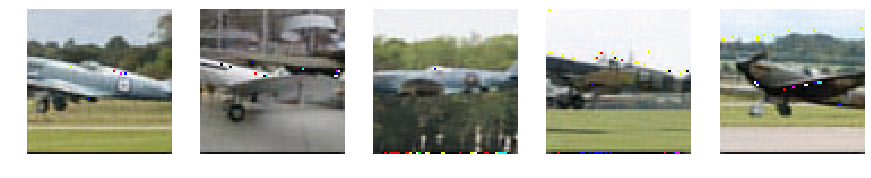

Epoch 31 /50 - loss = 81.19030029296874
Epoch 32 /50 - loss = 80.06582794189453
Epoch 33 /50 - loss = 84.03095825195312
Epoch 34 /50 - loss = 76.36173645019531
Epoch 35 /50 - loss = 82.92834930419922
Epoch 36 /50 - loss = 74.59673461914062
Epoch 37 /50 - loss = 75.10638671875
Epoch 38 /50 - loss = 75.18900085449219
Epoch 39 /50 - loss = 72.14975646972657
Epoch 40 /50 - loss = 67.07311706542968


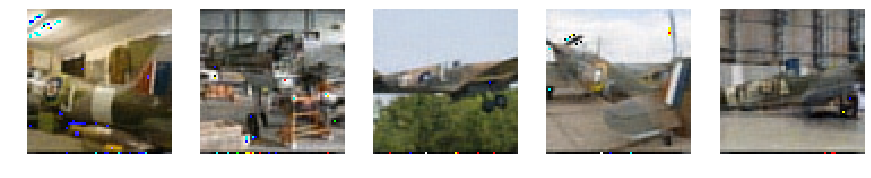

Epoch 41 /50 - loss = 78.26841491699219
Epoch 42 /50 - loss = 60.83754913330078
Epoch 43 /50 - loss = 59.529843139648435
Epoch 44 /50 - loss = 60.49886749267578
Epoch 45 /50 - loss = 58.56090759277344
Epoch 46 /50 - loss = 59.342678985595704
Epoch 47 /50 - loss = 56.16276245117187
Epoch 48 /50 - loss = 56.61763885498047
Epoch 49 /50 - loss = 58.308599853515624
Epoch 50 /50 - loss = 56.80620330810547


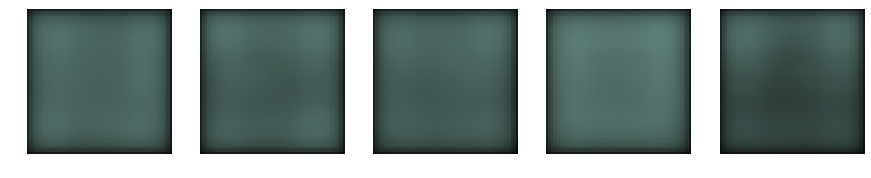

Epoch 1 /50 - loss = 5468.160159040179
Epoch 2 /50 - loss = 3227.59892578125
Epoch 3 /50 - loss = 1997.8502887834823
Epoch 4 /50 - loss = 1364.2861411830356
Epoch 5 /50 - loss = 701.2345375279018
Epoch 6 /50 - loss = 572.6004823521205
Epoch 7 /50 - loss = 442.4220178222656
Epoch 8 /50 - loss = 320.13205357142857
Epoch 9 /50 - loss = 245.22542942592077
Epoch 10 /50 - loss = 186.94203229631697


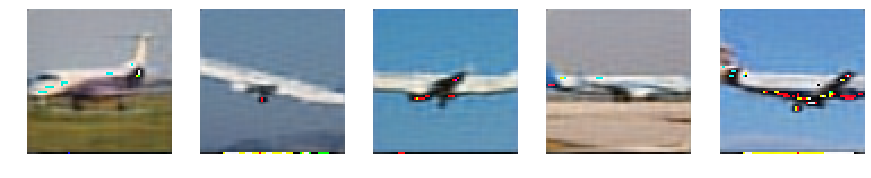

Epoch 11 /50 - loss = 152.69798993791852
Epoch 12 /50 - loss = 126.15233197893416
Epoch 13 /50 - loss = 107.3463268171038
Epoch 14 /50 - loss = 98.50379050118583
Epoch 15 /50 - loss = 87.99951167515346
Epoch 16 /50 - loss = 81.13268947056362
Epoch 17 /50 - loss = 75.22630144391741
Epoch 18 /50 - loss = 69.75502567836216
Epoch 19 /50 - loss = 67.42335662841796
Epoch 20 /50 - loss = 62.468713117327006


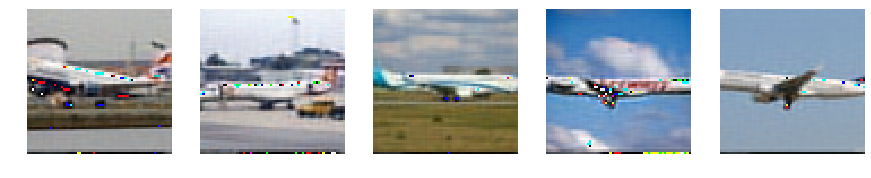

Epoch 21 /50 - loss = 62.32214815412249
Epoch 22 /50 - loss = 67.19554696219308
Epoch 23 /50 - loss = 58.67321611676898
Epoch 24 /50 - loss = 60.64283296857561
Epoch 25 /50 - loss = 54.09280055454799
Epoch 26 /50 - loss = 55.419722726004466
Epoch 27 /50 - loss = 55.668917476109094
Epoch 28 /50 - loss = 56.14994958060128
Epoch 29 /50 - loss = 50.12136642456055
Epoch 30 /50 - loss = 48.283708823067805


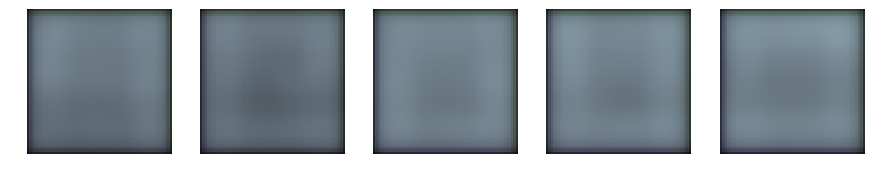

Epoch 1 /50 - loss = 3998.840896935096
Epoch 2 /50 - loss = 2285.953840519832
Epoch 3 /50 - loss = 1432.3800751201923
Epoch 4 /50 - loss = 913.9374928635817
Epoch 5 /50 - loss = 532.5340283203125
Epoch 6 /50 - loss = 430.29100501427286
Epoch 7 /50 - loss = 331.9156951434796
Epoch 8 /50 - loss = 233.43696326622597
Epoch 9 /50 - loss = 146.92551940917969
Epoch 10 /50 - loss = 107.88282212477463


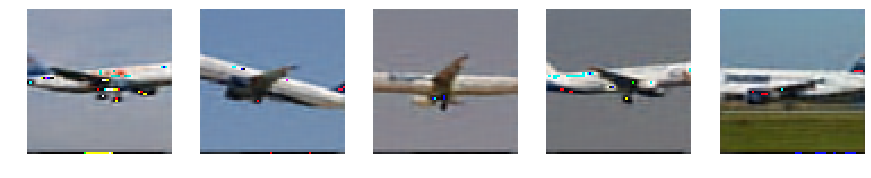

Epoch 11 /50 - loss = 89.11687295766977
Epoch 12 /50 - loss = 73.55784956711989
Epoch 13 /50 - loss = 63.75271127554087
Epoch 14 /50 - loss = 56.945250455416165
Epoch 15 /50 - loss = 52.9045046879695
Epoch 16 /50 - loss = 50.28804384671725
Epoch 17 /50 - loss = 46.65940675001878


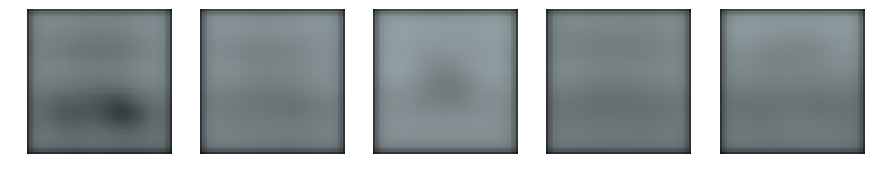

Epoch 1 /50 - loss = 3817.7080894886362
Epoch 2 /50 - loss = 2115.4315988991475
Epoch 3 /50 - loss = 1278.186913618608
Epoch 4 /50 - loss = 706.3538270152699
Epoch 5 /50 - loss = 462.8309335049716
Epoch 6 /50 - loss = 352.2010656738281
Epoch 7 /50 - loss = 265.3285303844105
Epoch 8 /50 - loss = 167.7920027854226
Epoch 9 /50 - loss = 104.33007546164772
Epoch 10 /50 - loss = 76.30870918967507


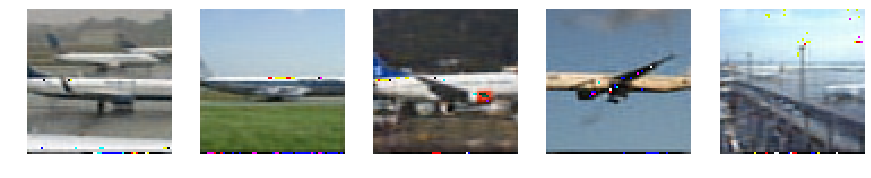

Epoch 11 /50 - loss = 62.335818550803445
Epoch 12 /50 - loss = 55.94235881458629
Epoch 13 /50 - loss = 49.66472818548029


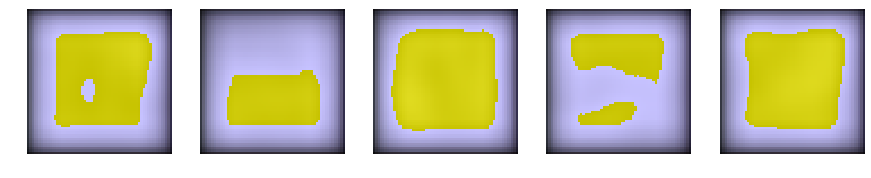

Epoch 1 /50 - loss = 11103.632421875
Epoch 2 /50 - loss = 6023.2155859375
Epoch 3 /50 - loss = 2594.392783203125
Epoch 4 /50 - loss = 1693.70509765625
Epoch 5 /50 - loss = 1253.078251953125
Epoch 6 /50 - loss = 1108.12603515625
Epoch 7 /50 - loss = 722.8597900390625
Epoch 8 /50 - loss = 509.8628955078125
Epoch 9 /50 - loss = 342.742724609375
Epoch 10 /50 - loss = 277.69952575683595


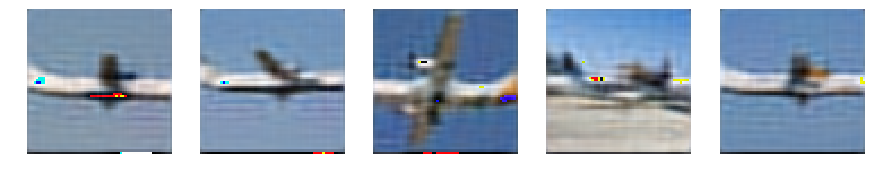

Epoch 11 /50 - loss = 232.3679833984375
Epoch 12 /50 - loss = 197.38950927734376
Epoch 13 /50 - loss = 174.40499938964842
Epoch 14 /50 - loss = 152.51219848632812
Epoch 15 /50 - loss = 133.9601138305664
Epoch 16 /50 - loss = 128.2492825317383
Epoch 17 /50 - loss = 115.39422302246093
Epoch 18 /50 - loss = 102.48388549804687
Epoch 19 /50 - loss = 108.0717919921875
Epoch 20 /50 - loss = 96.27138732910156


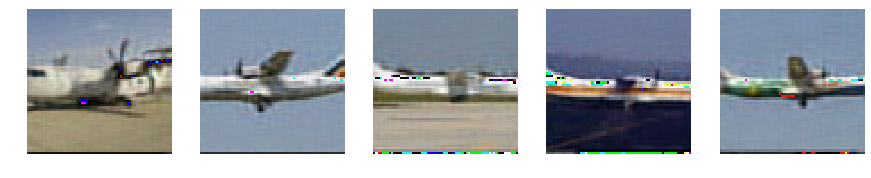

Epoch 21 /50 - loss = 90.90503112792969
Epoch 22 /50 - loss = 84.16742126464844
Epoch 23 /50 - loss = 80.08922302246094
Epoch 24 /50 - loss = 76.29915466308594
Epoch 25 /50 - loss = 77.13618347167969
Epoch 26 /50 - loss = 70.94841369628907
Epoch 27 /50 - loss = 69.71024154663085
Epoch 28 /50 - loss = 71.49271911621094
Epoch 29 /50 - loss = 66.40751800537109
Epoch 30 /50 - loss = 70.65288360595703


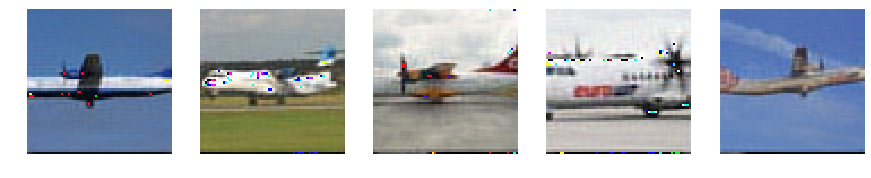

Epoch 31 /50 - loss = 62.05489212036133
Epoch 32 /50 - loss = 61.27315612792969
Epoch 33 /50 - loss = 58.617942352294925
Epoch 34 /50 - loss = 57.019197387695314
Epoch 35 /50 - loss = 54.56225723266601
Epoch 36 /50 - loss = 53.34691131591797
Epoch 37 /50 - loss = 53.34268341064453
Epoch 38 /50 - loss = 51.384510345458985
Epoch 39 /50 - loss = 51.827904510498044
Epoch 40 /50 - loss = 54.042755584716794


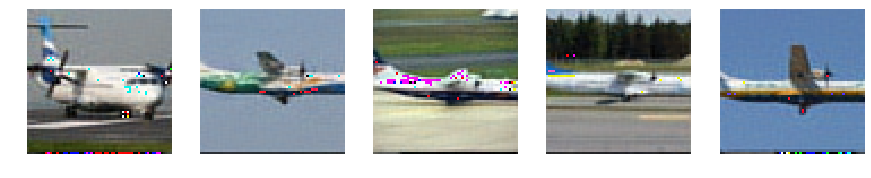

Epoch 41 /50 - loss = 50.65599334716797
Epoch 42 /50 - loss = 49.067523345947265


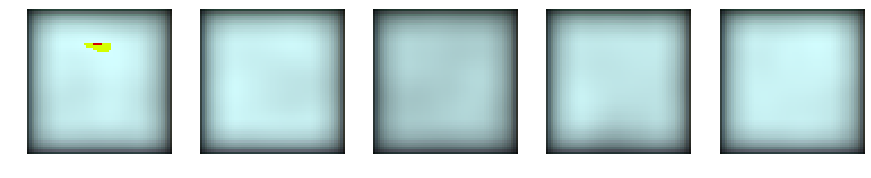

Epoch 1 /50 - loss = 10190.7216796875
Epoch 2 /50 - loss = 5787.21251953125
Epoch 3 /50 - loss = 2292.184638671875
Epoch 4 /50 - loss = 1578.809033203125
Epoch 5 /50 - loss = 1162.9585791015625
Epoch 6 /50 - loss = 943.4831591796875
Epoch 7 /50 - loss = 655.0625244140625
Epoch 8 /50 - loss = 445.8190600585938
Epoch 9 /50 - loss = 334.05380859375
Epoch 10 /50 - loss = 272.81080810546877


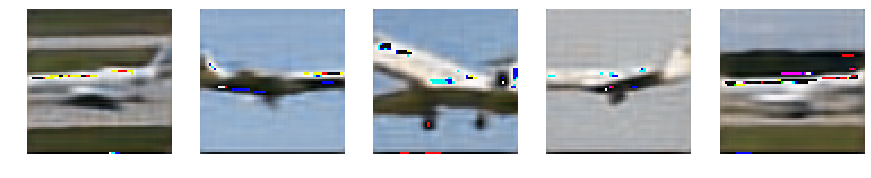

Epoch 11 /50 - loss = 243.16564575195312
Epoch 12 /50 - loss = 196.25413024902343
Epoch 13 /50 - loss = 185.43897705078126
Epoch 14 /50 - loss = 147.0537939453125
Epoch 15 /50 - loss = 134.3917401123047
Epoch 16 /50 - loss = 120.94133361816407
Epoch 17 /50 - loss = 123.72264526367188
Epoch 18 /50 - loss = 109.20035614013672
Epoch 19 /50 - loss = 101.9922882080078
Epoch 20 /50 - loss = 94.46083129882813


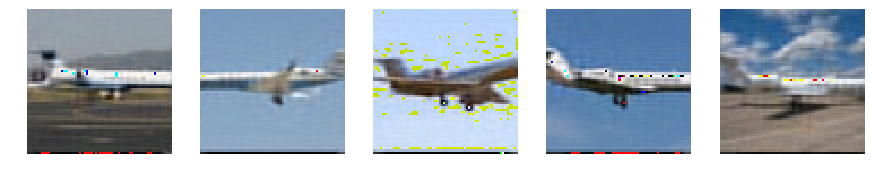

Epoch 21 /50 - loss = 92.36308288574219
Epoch 22 /50 - loss = 80.15593200683594
Epoch 23 /50 - loss = 73.65127746582031
Epoch 24 /50 - loss = 72.86421936035157
Epoch 25 /50 - loss = 71.24774993896484
Epoch 26 /50 - loss = 67.31011657714843
Epoch 27 /50 - loss = 62.29724670410156
Epoch 28 /50 - loss = 60.12760925292969
Epoch 29 /50 - loss = 57.88869201660156
Epoch 30 /50 - loss = 62.90841827392578


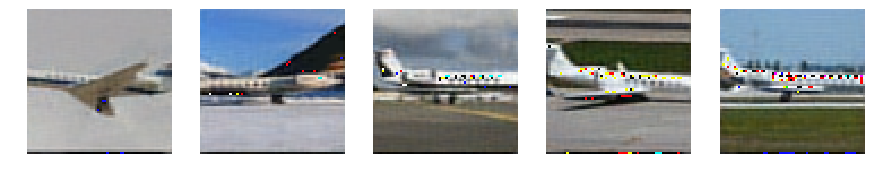

Epoch 31 /50 - loss = 69.11970092773437
Epoch 32 /50 - loss = 52.812869262695315
Epoch 33 /50 - loss = 56.31763763427735
Epoch 34 /50 - loss = 50.224452362060546
Epoch 35 /50 - loss = 58.77051879882813
Epoch 36 /50 - loss = 45.33289245605469


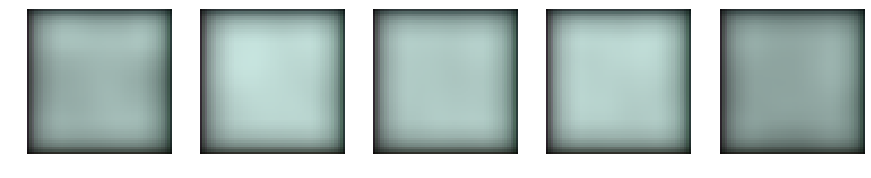

Epoch 1 /50 - loss = 9030.47640625
Epoch 2 /50 - loss = 5687.833154296875
Epoch 3 /50 - loss = 2980.826484375
Epoch 4 /50 - loss = 1884.7787353515625
Epoch 5 /50 - loss = 1300.629443359375
Epoch 6 /50 - loss = 1050.7880859375
Epoch 7 /50 - loss = 780.574716796875
Epoch 8 /50 - loss = 584.3127685546875
Epoch 9 /50 - loss = 394.0373376464844
Epoch 10 /50 - loss = 327.1539990234375


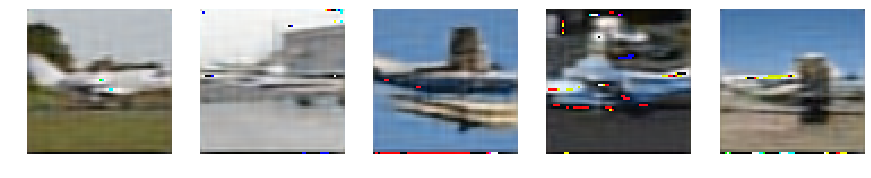

Epoch 11 /50 - loss = 275.246767578125
Epoch 12 /50 - loss = 240.74704345703125
Epoch 13 /50 - loss = 224.12090881347658
Epoch 14 /50 - loss = 189.66033935546875
Epoch 15 /50 - loss = 174.12344848632813
Epoch 16 /50 - loss = 161.56124572753907
Epoch 17 /50 - loss = 156.23960388183593
Epoch 18 /50 - loss = 139.05404663085938
Epoch 19 /50 - loss = 131.0017840576172
Epoch 20 /50 - loss = 124.16976196289062


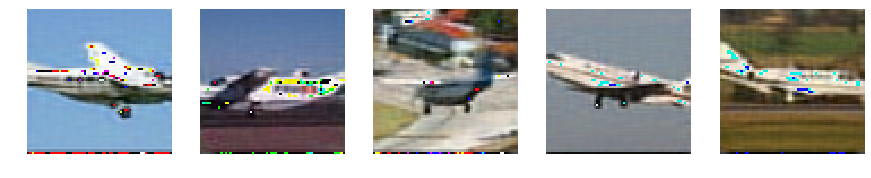

Epoch 21 /50 - loss = 118.4621435546875
Epoch 22 /50 - loss = 113.70268005371094
Epoch 23 /50 - loss = 108.03896057128907
Epoch 24 /50 - loss = 101.98803588867187
Epoch 25 /50 - loss = 99.62449768066406
Epoch 26 /50 - loss = 93.05061126708985
Epoch 27 /50 - loss = 96.70306335449219
Epoch 28 /50 - loss = 89.37123413085938
Epoch 29 /50 - loss = 87.26843139648437
Epoch 30 /50 - loss = 87.00058776855468


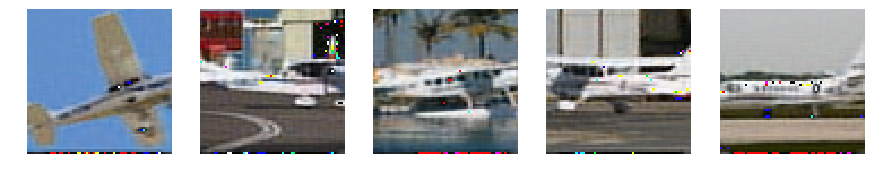

Epoch 31 /50 - loss = 81.31847259521484
Epoch 32 /50 - loss = 79.0392349243164
Epoch 33 /50 - loss = 76.18815979003907
Epoch 34 /50 - loss = 80.65544189453125
Epoch 35 /50 - loss = 71.77330413818359
Epoch 36 /50 - loss = 75.27994262695313
Epoch 37 /50 - loss = 70.16512573242187
Epoch 38 /50 - loss = 69.0977587890625
Epoch 39 /50 - loss = 73.76085388183594
Epoch 40 /50 - loss = 66.32957092285156


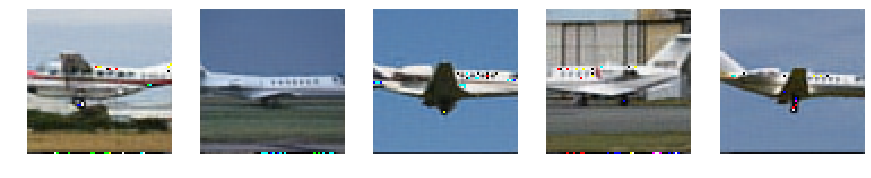

Epoch 41 /50 - loss = 63.53649108886719
Epoch 42 /50 - loss = 66.12349548339844
Epoch 43 /50 - loss = 63.74897766113281
Epoch 44 /50 - loss = 59.737359619140626
Epoch 45 /50 - loss = 61.84225036621094
Epoch 46 /50 - loss = 63.99885467529297
Epoch 47 /50 - loss = 61.18361602783203
Epoch 48 /50 - loss = 62.619561767578126
Epoch 49 /50 - loss = 61.517855682373046
Epoch 50 /50 - loss = 58.195064086914066


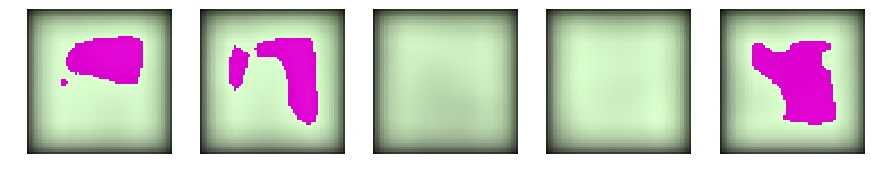

Epoch 1 /50 - loss = 10469.25703125
Epoch 2 /50 - loss = 7774.8241796875
Epoch 3 /50 - loss = 3203.15189453125
Epoch 4 /50 - loss = 2022.8594140625
Epoch 5 /50 - loss = 1500.5852978515625
Epoch 6 /50 - loss = 1295.8437890625
Epoch 7 /50 - loss = 841.755
Epoch 8 /50 - loss = 635.0219116210938
Epoch 9 /50 - loss = 438.00970458984375
Epoch 10 /50 - loss = 344.5378515625


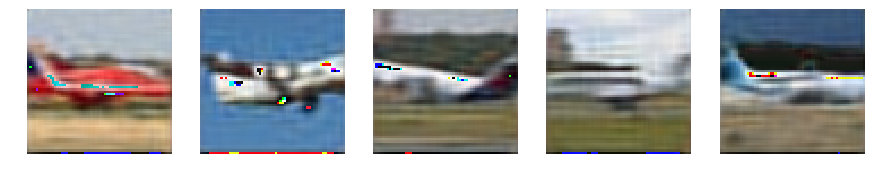

Epoch 11 /50 - loss = 286.53675048828126
Epoch 12 /50 - loss = 237.20713012695313
Epoch 13 /50 - loss = 204.0718017578125
Epoch 14 /50 - loss = 177.48825256347655
Epoch 15 /50 - loss = 166.38006774902342
Epoch 16 /50 - loss = 150.41273193359376
Epoch 17 /50 - loss = 149.94763793945313
Epoch 18 /50 - loss = 132.58751129150392
Epoch 19 /50 - loss = 122.98758605957032
Epoch 20 /50 - loss = 117.69183288574219


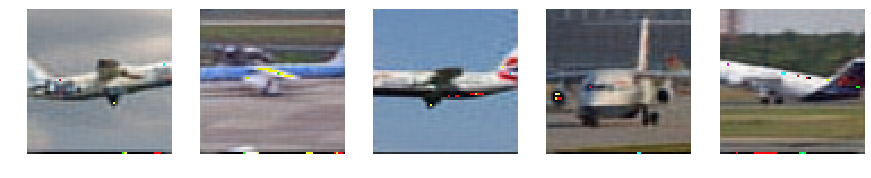

Epoch 21 /50 - loss = 118.02197631835938
Epoch 22 /50 - loss = 108.09101654052735
Epoch 23 /50 - loss = 108.06514526367188
Epoch 24 /50 - loss = 98.60303771972656
Epoch 25 /50 - loss = 94.50270141601563
Epoch 26 /50 - loss = 90.23652740478515
Epoch 27 /50 - loss = 93.03155090332031
Epoch 28 /50 - loss = 85.59553375244141
Epoch 29 /50 - loss = 83.74193359375
Epoch 30 /50 - loss = 80.9411312866211


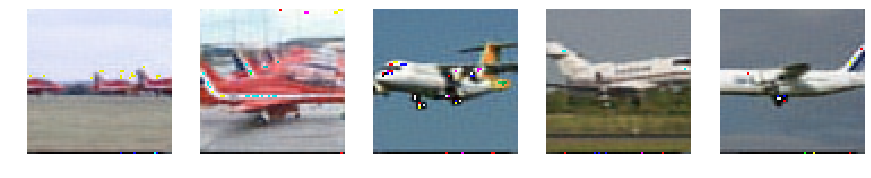

Epoch 31 /50 - loss = 78.19488830566407
Epoch 32 /50 - loss = 77.17007019042968
Epoch 33 /50 - loss = 73.78839172363281
Epoch 34 /50 - loss = 73.17768920898438
Epoch 35 /50 - loss = 73.20917785644531
Epoch 36 /50 - loss = 81.51497955322266
Epoch 37 /50 - loss = 69.7782666015625
Epoch 38 /50 - loss = 73.04334442138672
Epoch 39 /50 - loss = 65.46889831542968
Epoch 40 /50 - loss = 64.73781341552734


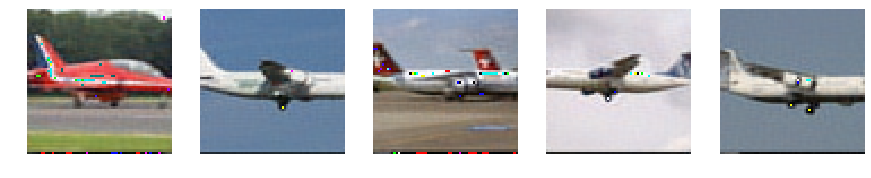

Epoch 41 /50 - loss = 66.45582229614257
Epoch 42 /50 - loss = 69.83293518066407
Epoch 43 /50 - loss = 66.16480834960937
Epoch 44 /50 - loss = 61.07861831665039
Epoch 45 /50 - loss = 63.87157958984375
Epoch 46 /50 - loss = 59.63955841064453
Epoch 47 /50 - loss = 60.7158268737793
Epoch 48 /50 - loss = 58.723844299316404
Epoch 49 /50 - loss = 58.49513610839844
Epoch 50 /50 - loss = 57.98614181518555


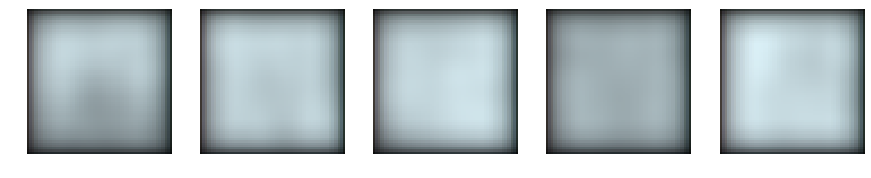

Epoch 1 /50 - loss = 8962.4434375
Epoch 2 /50 - loss = 7118.996953125
Epoch 3 /50 - loss = 2767.685107421875
Epoch 4 /50 - loss = 1734.15017578125
Epoch 5 /50 - loss = 1264.4507861328125
Epoch 6 /50 - loss = 1079.40697265625
Epoch 7 /50 - loss = 762.4494506835938
Epoch 8 /50 - loss = 540.5287768554688
Epoch 9 /50 - loss = 359.13323974609375
Epoch 10 /50 - loss = 296.0138854980469


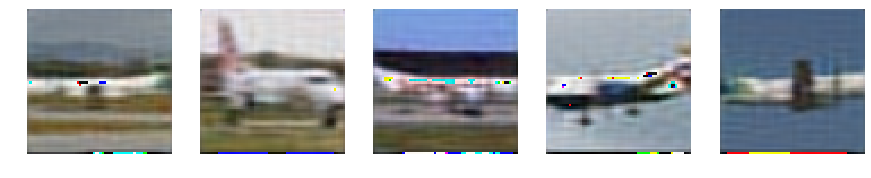

Epoch 11 /50 - loss = 242.29830993652342
Epoch 12 /50 - loss = 201.08729736328124
Epoch 13 /50 - loss = 190.38132568359376
Epoch 14 /50 - loss = 156.5312646484375
Epoch 15 /50 - loss = 136.67079711914062
Epoch 16 /50 - loss = 128.2295556640625
Epoch 17 /50 - loss = 115.32062286376953
Epoch 18 /50 - loss = 110.39420989990235
Epoch 19 /50 - loss = 99.16056091308593
Epoch 20 /50 - loss = 91.99031799316407


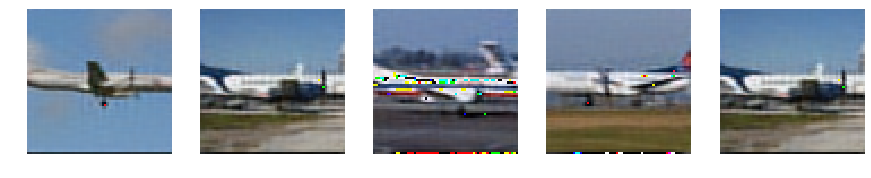

Epoch 21 /50 - loss = 88.05192138671875
Epoch 22 /50 - loss = 84.66872009277344
Epoch 23 /50 - loss = 76.78702453613282
Epoch 24 /50 - loss = 73.93290466308594
Epoch 25 /50 - loss = 69.12198272705078
Epoch 26 /50 - loss = 76.92458984375
Epoch 27 /50 - loss = 67.5766177368164
Epoch 28 /50 - loss = 68.2550309753418
Epoch 29 /50 - loss = 62.630874938964844
Epoch 30 /50 - loss = 65.60297836303711


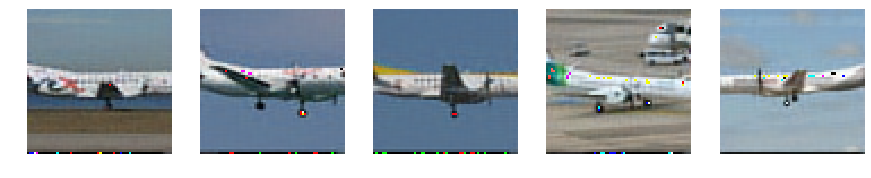

Epoch 31 /50 - loss = 55.13641174316406
Epoch 32 /50 - loss = 54.21100982666016
Epoch 33 /50 - loss = 53.46955322265625
Epoch 34 /50 - loss = 52.25871368408203
Epoch 35 /50 - loss = 54.88966827392578
Epoch 36 /50 - loss = 51.2415576171875
Epoch 37 /50 - loss = 54.04556243896484
Epoch 38 /50 - loss = 48.20616394042969


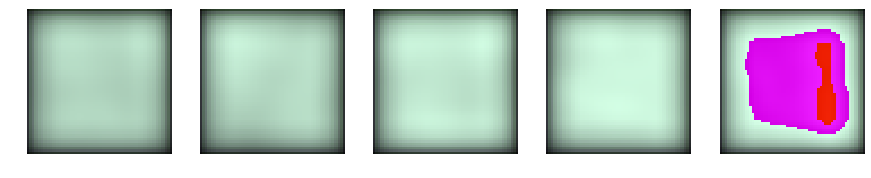

Epoch 1 /50 - loss = 11896.5050703125
Epoch 2 /50 - loss = 6202.40659765625
Epoch 3 /50 - loss = 2894.7467734375
Epoch 4 /50 - loss = 1909.6441904296876
Epoch 5 /50 - loss = 1334.0446064453124
Epoch 6 /50 - loss = 991.8418315429687
Epoch 7 /50 - loss = 745.2478813476563
Epoch 8 /50 - loss = 589.6271059570313
Epoch 9 /50 - loss = 433.36027954101564
Epoch 10 /50 - loss = 372.7711936035156


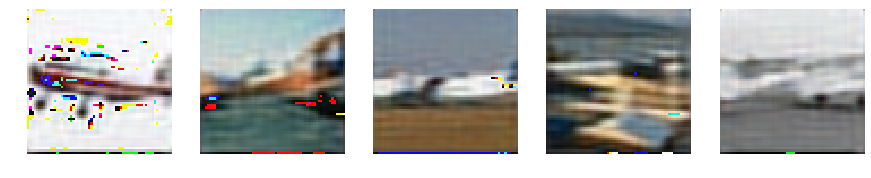

Epoch 11 /50 - loss = 329.2251928710937
Epoch 12 /50 - loss = 259.7441416015625
Epoch 13 /50 - loss = 230.2807537841797
Epoch 14 /50 - loss = 204.8640732421875
Epoch 15 /50 - loss = 193.45257873535155
Epoch 16 /50 - loss = 176.32147094726562
Epoch 17 /50 - loss = 165.0576378173828
Epoch 18 /50 - loss = 155.41097485351563
Epoch 19 /50 - loss = 145.23842919921876
Epoch 20 /50 - loss = 147.48249169921874


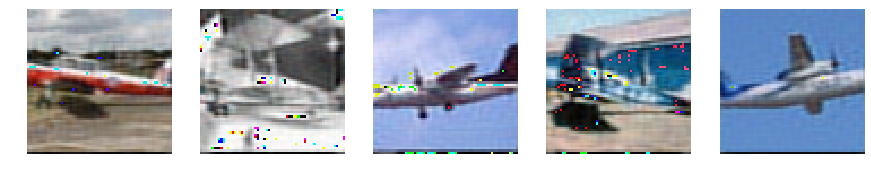

Epoch 21 /50 - loss = 131.64096350097657
Epoch 22 /50 - loss = 130.5856033935547
Epoch 23 /50 - loss = 123.94831463623046
Epoch 24 /50 - loss = 116.37131811523437
Epoch 25 /50 - loss = 115.41001892089844
Epoch 26 /50 - loss = 111.85198034667968
Epoch 27 /50 - loss = 109.99755090332032
Epoch 28 /50 - loss = 103.07781170654297
Epoch 29 /50 - loss = 102.15918005371094
Epoch 30 /50 - loss = 112.31722106933594


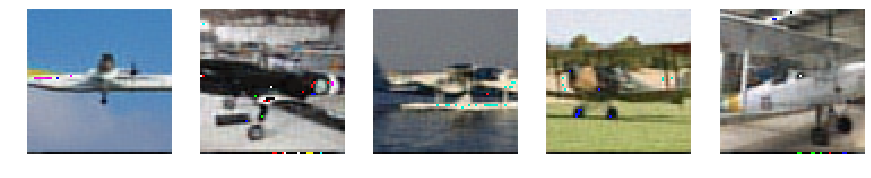

Epoch 31 /50 - loss = 97.82414794921876
Epoch 32 /50 - loss = 98.24539495849609
Epoch 33 /50 - loss = 91.58716198730468
Epoch 34 /50 - loss = 89.80041448974609
Epoch 35 /50 - loss = 93.35677368164062
Epoch 36 /50 - loss = 96.10275854492187
Epoch 37 /50 - loss = 85.17633978271485
Epoch 38 /50 - loss = 84.80339575195312
Epoch 39 /50 - loss = 84.0624086303711
Epoch 40 /50 - loss = 91.35919744873047


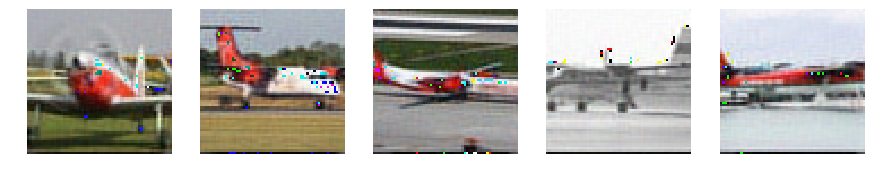

Epoch 41 /50 - loss = 81.89023071289063
Epoch 42 /50 - loss = 88.38367980957031
Epoch 43 /50 - loss = 81.8747251586914
Epoch 44 /50 - loss = 79.18728240966797
Epoch 45 /50 - loss = 77.88444213867187
Epoch 46 /50 - loss = 76.97989782714843
Epoch 47 /50 - loss = 76.20507885742188
Epoch 48 /50 - loss = 74.88944104003906
Epoch 49 /50 - loss = 74.72309008789063
Epoch 50 /50 - loss = 73.54018298339844


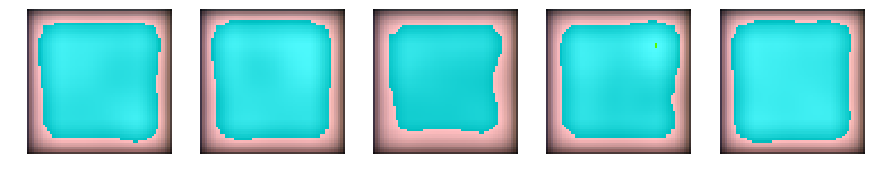

Epoch 1 /50 - loss = 14468.28951171875
Epoch 2 /50 - loss = 7226.8321484375
Epoch 3 /50 - loss = 2987.310498046875
Epoch 4 /50 - loss = 1739.835576171875
Epoch 5 /50 - loss = 1270.249990234375
Epoch 6 /50 - loss = 1033.31810546875
Epoch 7 /50 - loss = 696.244169921875
Epoch 8 /50 - loss = 478.5802258300781
Epoch 9 /50 - loss = 319.1706909179687
Epoch 10 /50 - loss = 315.4753356933594


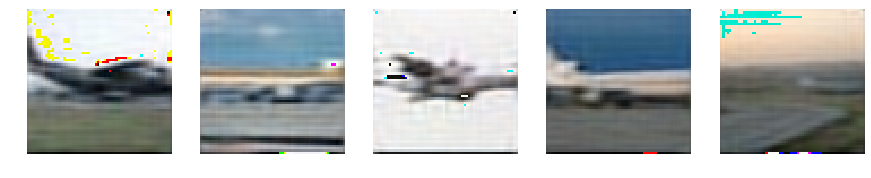

Epoch 11 /50 - loss = 220.02870361328124
Epoch 12 /50 - loss = 182.41373413085938
Epoch 13 /50 - loss = 155.34809631347656
Epoch 14 /50 - loss = 137.04963500976564
Epoch 15 /50 - loss = 122.67359436035156
Epoch 16 /50 - loss = 121.37752502441407
Epoch 17 /50 - loss = 110.24907104492188
Epoch 18 /50 - loss = 97.18926116943359
Epoch 19 /50 - loss = 90.69045562744141
Epoch 20 /50 - loss = 82.19809051513671


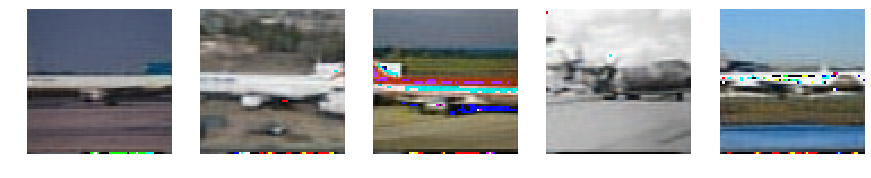

Epoch 21 /50 - loss = 81.31245391845704
Epoch 22 /50 - loss = 76.4987646484375
Epoch 23 /50 - loss = 72.48017822265625
Epoch 24 /50 - loss = 66.90769409179687
Epoch 25 /50 - loss = 65.3269775390625
Epoch 26 /50 - loss = 65.38452713012695
Epoch 27 /50 - loss = 57.774540405273434
Epoch 28 /50 - loss = 56.64292755126953
Epoch 29 /50 - loss = 55.63076171875
Epoch 30 /50 - loss = 52.69917510986328


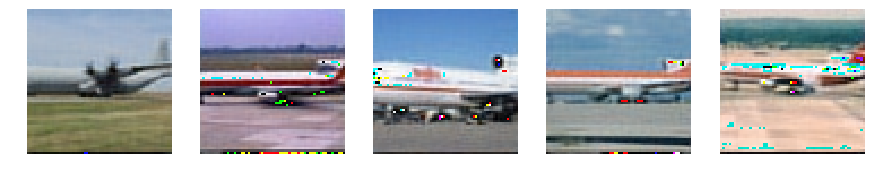

Epoch 31 /50 - loss = 53.403555908203124
Epoch 32 /50 - loss = 50.68352432250977
Epoch 33 /50 - loss = 50.46368591308594
Epoch 34 /50 - loss = 55.60927764892578
Epoch 35 /50 - loss = 48.74022766113281


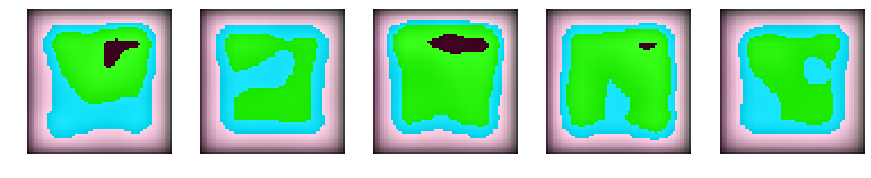

Epoch 1 /50 - loss = 12199.4374609375
Epoch 2 /50 - loss = 8194.4467578125
Epoch 3 /50 - loss = 3371.365009765625
Epoch 4 /50 - loss = 1895.375478515625
Epoch 5 /50 - loss = 1436.38615234375
Epoch 6 /50 - loss = 1274.2919873046876
Epoch 7 /50 - loss = 851.825361328125
Epoch 8 /50 - loss = 616.74185546875
Epoch 9 /50 - loss = 437.4522436523437
Epoch 10 /50 - loss = 357.4032836914063


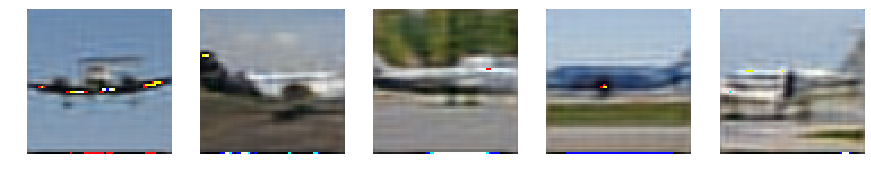

Epoch 11 /50 - loss = 299.9045233154297
Epoch 12 /50 - loss = 257.8494970703125
Epoch 13 /50 - loss = 222.58419921875
Epoch 14 /50 - loss = 207.80936401367188
Epoch 15 /50 - loss = 183.71154907226563
Epoch 16 /50 - loss = 162.49545288085938
Epoch 17 /50 - loss = 157.32257080078125
Epoch 18 /50 - loss = 146.84771362304687
Epoch 19 /50 - loss = 130.06730041503906
Epoch 20 /50 - loss = 129.40713500976562


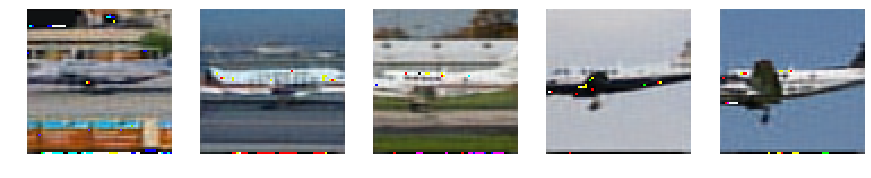

Epoch 21 /50 - loss = 129.7145098876953
Epoch 22 /50 - loss = 115.08863647460937
Epoch 23 /50 - loss = 103.16824645996094
Epoch 24 /50 - loss = 99.23644409179687
Epoch 25 /50 - loss = 99.24880249023437
Epoch 26 /50 - loss = 94.96724914550781
Epoch 27 /50 - loss = 89.76475463867187
Epoch 28 /50 - loss = 85.78861206054688
Epoch 29 /50 - loss = 91.529658203125
Epoch 30 /50 - loss = 77.9221142578125


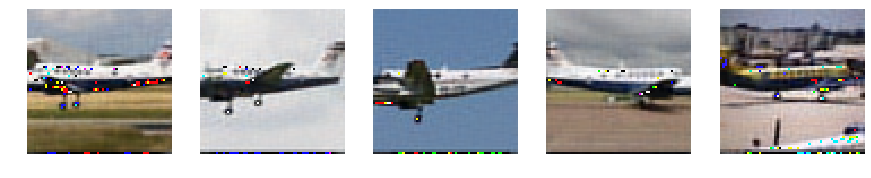

Epoch 31 /50 - loss = 76.97540832519532
Epoch 32 /50 - loss = 92.60025146484375
Epoch 33 /50 - loss = 79.70495910644532
Epoch 34 /50 - loss = 75.90440612792969
Epoch 35 /50 - loss = 74.13948791503907
Epoch 36 /50 - loss = 68.42172729492188
Epoch 37 /50 - loss = 70.5348046875
Epoch 38 /50 - loss = 67.60668762207031
Epoch 39 /50 - loss = 65.06656494140626
Epoch 40 /50 - loss = 61.50073303222656


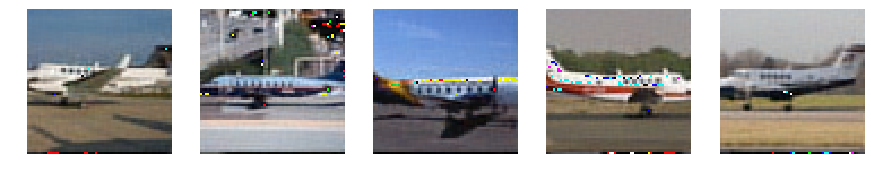

Epoch 41 /50 - loss = 62.335607299804686
Epoch 42 /50 - loss = 58.66969223022461
Epoch 43 /50 - loss = 58.19980560302734
Epoch 44 /50 - loss = 61.24027755737305
Epoch 45 /50 - loss = 55.39264892578125
Epoch 46 /50 - loss = 54.56529037475586
Epoch 47 /50 - loss = 57.0931201171875
Epoch 48 /50 - loss = 54.022887268066405
Epoch 49 /50 - loss = 53.49955841064453
Epoch 50 /50 - loss = 53.874436645507814


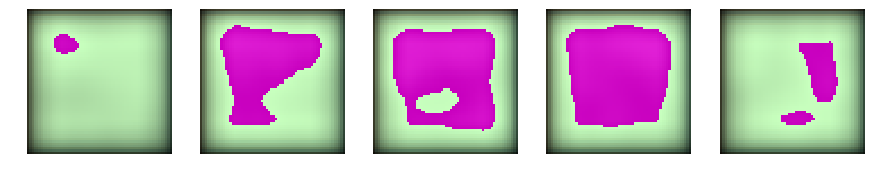

Epoch 1 /50 - loss = 12491.66015625
Epoch 2 /50 - loss = 6973.955078125
Epoch 3 /50 - loss = 3078.468212890625
Epoch 4 /50 - loss = 1670.638701171875
Epoch 5 /50 - loss = 1212.796572265625
Epoch 6 /50 - loss = 1031.0256787109374
Epoch 7 /50 - loss = 724.408154296875
Epoch 8 /50 - loss = 534.488349609375
Epoch 9 /50 - loss = 361.7751135253906
Epoch 10 /50 - loss = 293.66166259765623


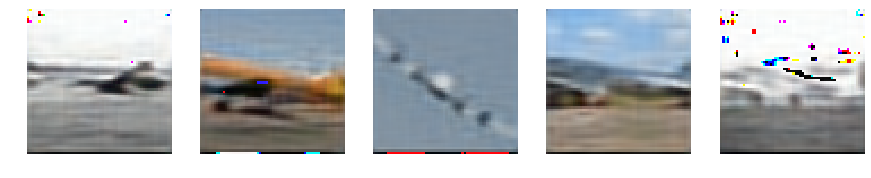

Epoch 11 /50 - loss = 238.4958203125
Epoch 12 /50 - loss = 201.93684631347656
Epoch 13 /50 - loss = 175.91694091796876
Epoch 14 /50 - loss = 161.2026501464844
Epoch 15 /50 - loss = 154.308291015625
Epoch 16 /50 - loss = 130.61852966308595
Epoch 17 /50 - loss = 115.16017517089844
Epoch 18 /50 - loss = 106.3930972290039
Epoch 19 /50 - loss = 99.8198812866211
Epoch 20 /50 - loss = 105.26349090576171


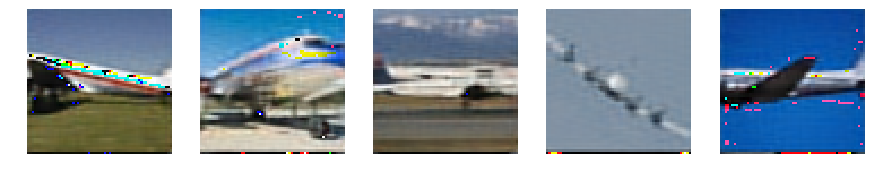

Epoch 21 /50 - loss = 94.92632293701172
Epoch 22 /50 - loss = 88.67681427001953
Epoch 23 /50 - loss = 81.76923095703125
Epoch 24 /50 - loss = 78.68651306152344
Epoch 25 /50 - loss = 74.84538604736328
Epoch 26 /50 - loss = 73.11887908935547
Epoch 27 /50 - loss = 68.80664459228515
Epoch 28 /50 - loss = 70.21235076904297
Epoch 29 /50 - loss = 71.55329315185547
Epoch 30 /50 - loss = 66.70380065917969


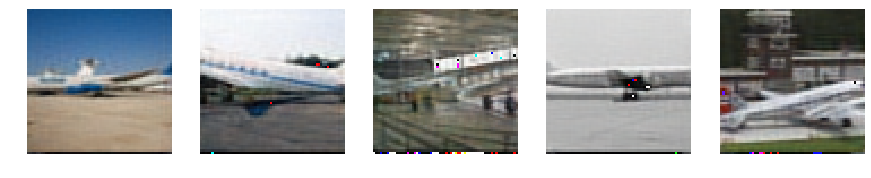

Epoch 31 /50 - loss = 61.411745910644534
Epoch 32 /50 - loss = 64.46997650146484
Epoch 33 /50 - loss = 59.786696166992186
Epoch 34 /50 - loss = 56.8955581665039
Epoch 35 /50 - loss = 55.28287353515625
Epoch 36 /50 - loss = 55.11517669677735
Epoch 37 /50 - loss = 55.63505615234375
Epoch 38 /50 - loss = 52.72040313720703
Epoch 39 /50 - loss = 52.594000244140624
Epoch 40 /50 - loss = 52.06208770751953


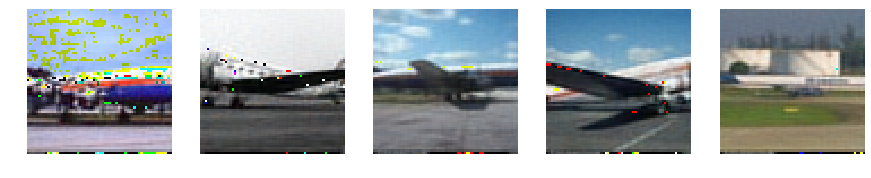

Epoch 41 /50 - loss = 51.161559143066405
Epoch 42 /50 - loss = 48.92551116943359


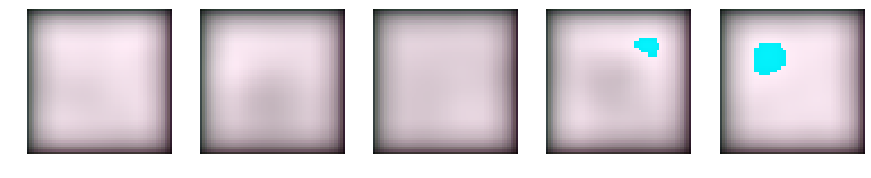

Epoch 1 /50 - loss = 10694.654140625
Epoch 2 /50 - loss = 6376.07341796875
Epoch 3 /50 - loss = 2571.767822265625
Epoch 4 /50 - loss = 1681.65943359375
Epoch 5 /50 - loss = 1189.786064453125
Epoch 6 /50 - loss = 1028.7517993164063
Epoch 7 /50 - loss = 666.7438891601563
Epoch 8 /50 - loss = 483.846181640625
Epoch 9 /50 - loss = 404.7284326171875
Epoch 10 /50 - loss = 255.58325012207033


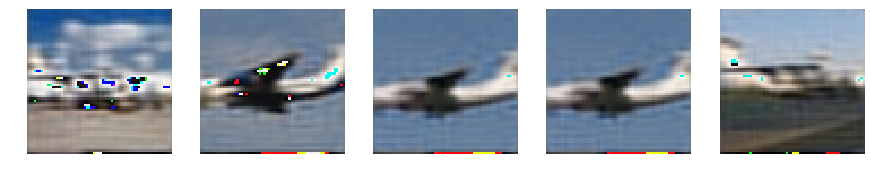

Epoch 11 /50 - loss = 223.34498168945314
Epoch 12 /50 - loss = 231.2388720703125
Epoch 13 /50 - loss = 152.17101928710937
Epoch 14 /50 - loss = 132.9530401611328
Epoch 15 /50 - loss = 119.18648864746093
Epoch 16 /50 - loss = 105.61053436279298
Epoch 17 /50 - loss = 94.13874237060547
Epoch 18 /50 - loss = 88.01427886962891
Epoch 19 /50 - loss = 81.16199462890626
Epoch 20 /50 - loss = 78.84595123291015


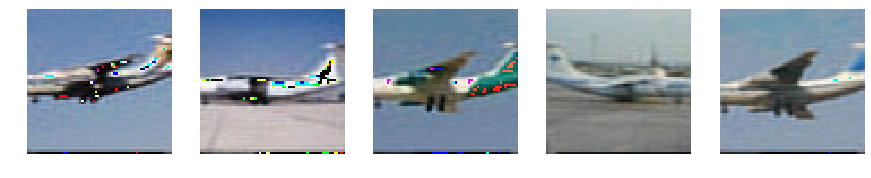

Epoch 21 /50 - loss = 74.26654998779297
Epoch 22 /50 - loss = 70.49510757446289
Epoch 23 /50 - loss = 65.43271545410157
Epoch 24 /50 - loss = 60.537704162597656
Epoch 25 /50 - loss = 77.01435241699218
Epoch 26 /50 - loss = 60.80849609375
Epoch 27 /50 - loss = 55.983096313476565
Epoch 28 /50 - loss = 50.258706970214845
Epoch 29 /50 - loss = 50.16092987060547
Epoch 30 /50 - loss = 46.76115325927734


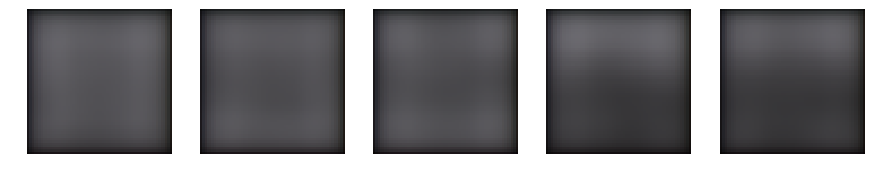

Epoch 1 /50 - loss = 5615.293694196429
Epoch 2 /50 - loss = 3739.1775334821427
Epoch 3 /50 - loss = 1997.6252504185268
Epoch 4 /50 - loss = 1364.0656961495536
Epoch 5 /50 - loss = 949.4214372907367
Epoch 6 /50 - loss = 804.816932547433
Epoch 7 /50 - loss = 495.5515673828125
Epoch 8 /50 - loss = 364.96873761858257
Epoch 9 /50 - loss = 247.790435093471
Epoch 10 /50 - loss = 183.1695596749442


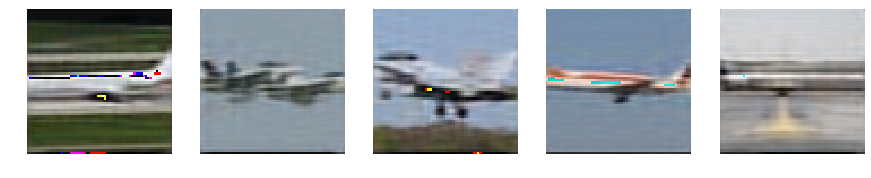

Epoch 11 /50 - loss = 142.40040954589844
Epoch 12 /50 - loss = 122.58949192592075
Epoch 13 /50 - loss = 110.50539773123604
Epoch 14 /50 - loss = 100.12044250488282
Epoch 15 /50 - loss = 89.83765747070312
Epoch 16 /50 - loss = 84.37527849469866
Epoch 17 /50 - loss = 75.4856358555385
Epoch 18 /50 - loss = 72.40992021833148
Epoch 19 /50 - loss = 70.9945090157645
Epoch 20 /50 - loss = 65.02158861432757


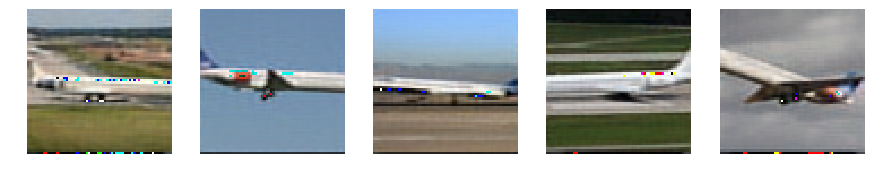

Epoch 21 /50 - loss = 62.16621778215681
Epoch 22 /50 - loss = 60.26322208949498
Epoch 23 /50 - loss = 56.31224890572684
Epoch 24 /50 - loss = 52.27889439174107
Epoch 25 /50 - loss = 52.46015141078404
Epoch 26 /50 - loss = 47.37636483328683


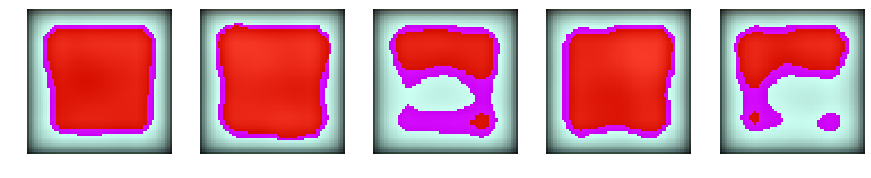

Epoch 1 /50 - loss = 14172.129296875
Epoch 2 /50 - loss = 8246.45568359375
Epoch 3 /50 - loss = 2965.176259765625
Epoch 4 /50 - loss = 1988.038125
Epoch 5 /50 - loss = 1328.5460791015626
Epoch 6 /50 - loss = 1180.718662109375
Epoch 7 /50 - loss = 901.7612084960938
Epoch 8 /50 - loss = 690.8180224609375
Epoch 9 /50 - loss = 476.018388671875
Epoch 10 /50 - loss = 373.83539916992186


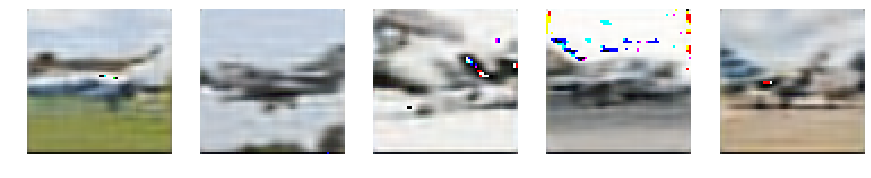

Epoch 11 /50 - loss = 320.4694885253906
Epoch 12 /50 - loss = 265.9731689453125
Epoch 13 /50 - loss = 229.4459490966797
Epoch 14 /50 - loss = 185.02557800292968
Epoch 15 /50 - loss = 161.25710571289062
Epoch 16 /50 - loss = 142.97973876953125
Epoch 17 /50 - loss = 129.7952587890625
Epoch 18 /50 - loss = 127.49818603515625
Epoch 19 /50 - loss = 113.31522613525391
Epoch 20 /50 - loss = 101.92870178222657


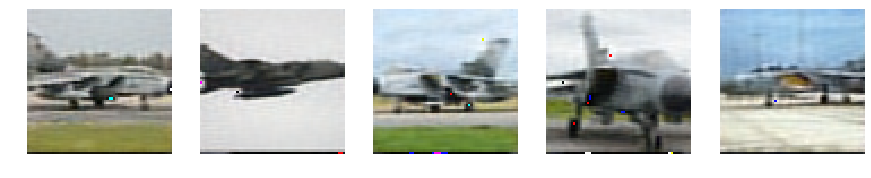

Epoch 21 /50 - loss = 93.54989929199219
Epoch 22 /50 - loss = 105.40879516601562
Epoch 23 /50 - loss = 81.96419158935547
Epoch 24 /50 - loss = 79.8724169921875
Epoch 25 /50 - loss = 76.1181069946289
Epoch 26 /50 - loss = 86.77875854492187
Epoch 27 /50 - loss = 68.65376571655274
Epoch 28 /50 - loss = 66.9993017578125
Epoch 29 /50 - loss = 62.95702896118164
Epoch 30 /50 - loss = 60.908252563476566


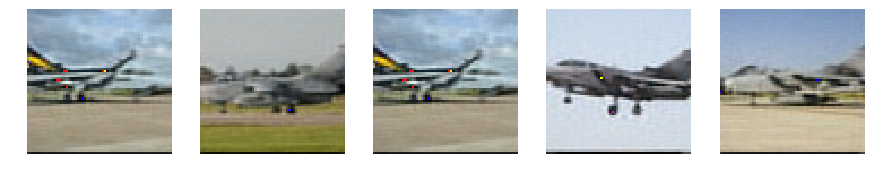

Epoch 31 /50 - loss = 67.41554550170899
Epoch 32 /50 - loss = 67.42233093261719
Epoch 33 /50 - loss = 55.25227172851562
Epoch 34 /50 - loss = 59.36797088623047
Epoch 35 /50 - loss = 55.019656066894534
Epoch 36 /50 - loss = 50.70797332763672
Epoch 37 /50 - loss = 58.50303863525391
Epoch 38 /50 - loss = 68.72355285644531
Epoch 39 /50 - loss = 47.86397644042969


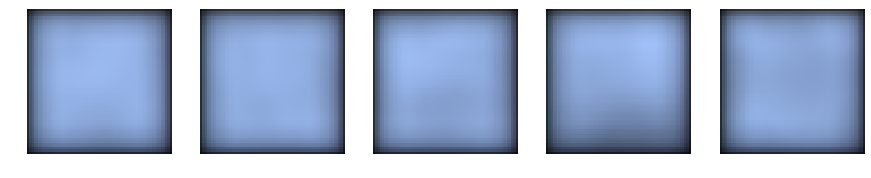

Epoch 1 /50 - loss = 9020.77744140625
Epoch 2 /50 - loss = 3848.58126953125
Epoch 3 /50 - loss = 2285.600947265625
Epoch 4 /50 - loss = 1452.5738671875
Epoch 5 /50 - loss = 998.398720703125
Epoch 6 /50 - loss = 725.0455029296875
Epoch 7 /50 - loss = 549.65150390625
Epoch 8 /50 - loss = 367.62966796875
Epoch 9 /50 - loss = 257.6392529296875
Epoch 10 /50 - loss = 194.5604669189453


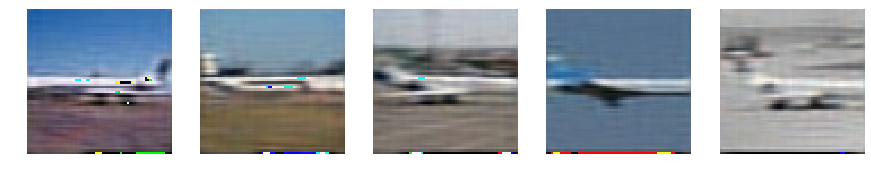

Epoch 11 /50 - loss = 154.6865661621094
Epoch 12 /50 - loss = 129.66742797851563
Epoch 13 /50 - loss = 113.09820770263671
Epoch 14 /50 - loss = 98.78992736816406
Epoch 15 /50 - loss = 107.92281463623047
Epoch 16 /50 - loss = 92.11396942138671
Epoch 17 /50 - loss = 78.04860168457031
Epoch 18 /50 - loss = 73.34986511230468
Epoch 19 /50 - loss = 73.18611938476562
Epoch 20 /50 - loss = 63.82384155273437


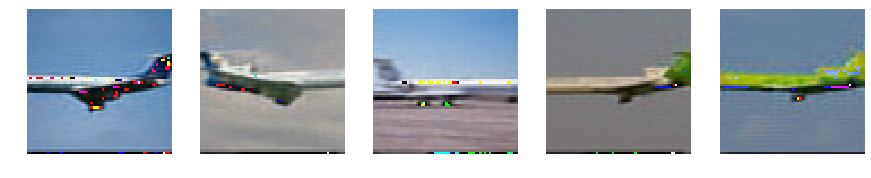

Epoch 21 /50 - loss = 61.33727737426758
Epoch 22 /50 - loss = 60.243006286621096
Epoch 23 /50 - loss = 56.9443359375
Epoch 24 /50 - loss = 54.607630310058596
Epoch 25 /50 - loss = 52.22505340576172
Epoch 26 /50 - loss = 51.99427734375
Epoch 27 /50 - loss = 46.705513610839844


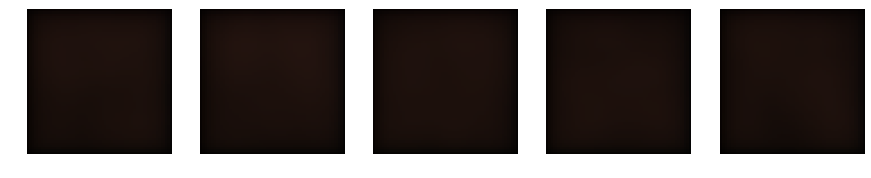

Epoch 1 /50 - loss = 19050.8240625
Epoch 2 /50 - loss = 6081.6304296875
Epoch 3 /50 - loss = 3830.41146484375
Epoch 4 /50 - loss = 1923.0607763671876
Epoch 5 /50 - loss = 1433.8102392578126
Epoch 6 /50 - loss = 1210.772587890625
Epoch 7 /50 - loss = 927.215107421875
Epoch 8 /50 - loss = 627.8687475585938
Epoch 9 /50 - loss = 432.8117822265625
Epoch 10 /50 - loss = 356.69144165039063


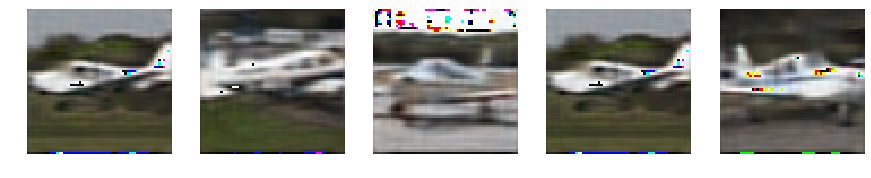

Epoch 11 /50 - loss = 293.4773962402344
Epoch 12 /50 - loss = 244.44037841796876
Epoch 13 /50 - loss = 211.91471313476563
Epoch 14 /50 - loss = 206.26628662109374
Epoch 15 /50 - loss = 169.98709594726563
Epoch 16 /50 - loss = 170.2541015625
Epoch 17 /50 - loss = 147.0923468017578
Epoch 18 /50 - loss = 128.21995849609374
Epoch 19 /50 - loss = 131.75830078125
Epoch 20 /50 - loss = 129.64688903808593


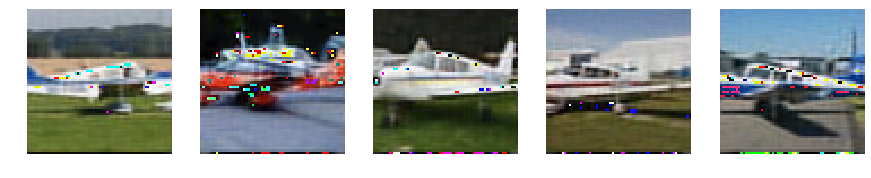

Epoch 21 /50 - loss = 108.14369171142579
Epoch 22 /50 - loss = 97.32239135742188
Epoch 23 /50 - loss = 99.804541015625
Epoch 24 /50 - loss = 90.97421173095704
Epoch 25 /50 - loss = 85.79376831054688
Epoch 26 /50 - loss = 80.68778350830078
Epoch 27 /50 - loss = 79.8053125
Epoch 28 /50 - loss = 80.05496887207032
Epoch 29 /50 - loss = 81.86878967285156
Epoch 30 /50 - loss = 69.96088302612304


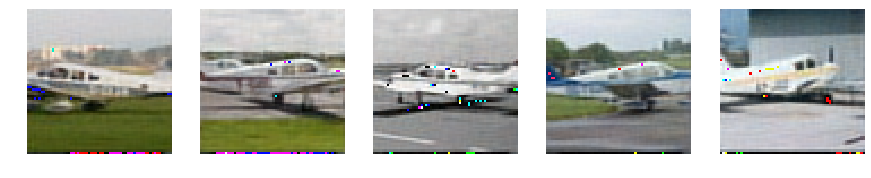

Epoch 31 /50 - loss = 76.23211364746093
Epoch 32 /50 - loss = 68.80468612670899
Epoch 33 /50 - loss = 76.20939392089844
Epoch 34 /50 - loss = 71.01374877929688
Epoch 35 /50 - loss = 59.724132690429684
Epoch 36 /50 - loss = 60.912493591308596
Epoch 37 /50 - loss = 56.67908599853516
Epoch 38 /50 - loss = 55.55862045288086
Epoch 39 /50 - loss = 55.20698364257812
Epoch 40 /50 - loss = 56.813251953125


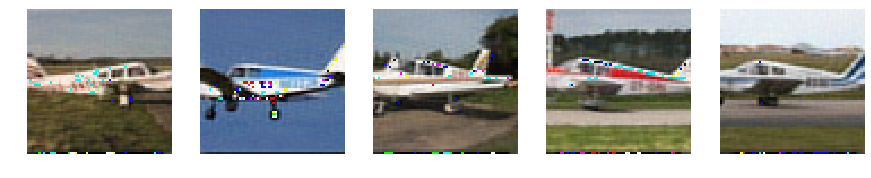

Epoch 41 /50 - loss = 53.87869934082031
Epoch 42 /50 - loss = 61.0011489868164
Epoch 43 /50 - loss = 49.544437866210934


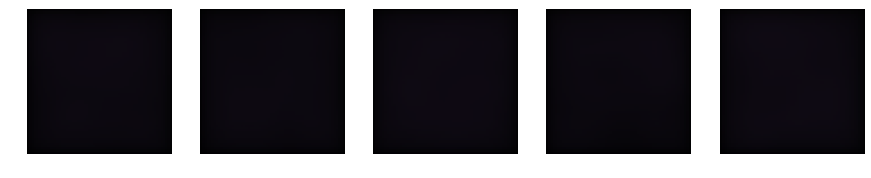

Epoch 1 /50 - loss = 20125.6484375
Epoch 2 /50 - loss = 11098.14203125
Epoch 3 /50 - loss = 3803.67751953125
Epoch 4 /50 - loss = 1905.119072265625
Epoch 5 /50 - loss = 1337.449873046875
Epoch 6 /50 - loss = 1226.664248046875
Epoch 7 /50 - loss = 784.1466870117188
Epoch 8 /50 - loss = 599.4722924804687
Epoch 9 /50 - loss = 419.35419921875
Epoch 10 /50 - loss = 313.632060546875


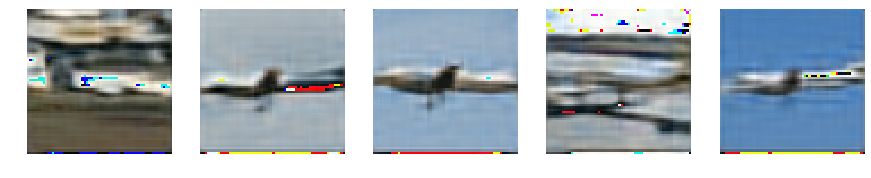

Epoch 11 /50 - loss = 260.18092041015626
Epoch 12 /50 - loss = 221.50595886230468
Epoch 13 /50 - loss = 192.04143798828125
Epoch 14 /50 - loss = 175.06918884277343
Epoch 15 /50 - loss = 154.45223999023438
Epoch 16 /50 - loss = 141.9128857421875
Epoch 17 /50 - loss = 132.4339337158203
Epoch 18 /50 - loss = 132.36023864746093
Epoch 19 /50 - loss = 111.66872741699218
Epoch 20 /50 - loss = 102.92062133789062


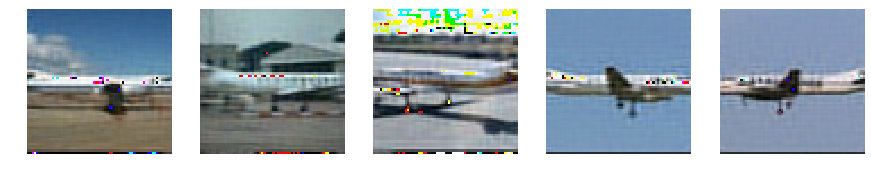

Epoch 21 /50 - loss = 96.6058837890625
Epoch 22 /50 - loss = 89.19855590820312
Epoch 23 /50 - loss = 86.41092254638671
Epoch 24 /50 - loss = 83.27283050537109
Epoch 25 /50 - loss = 78.8656948852539
Epoch 26 /50 - loss = 76.65835632324219
Epoch 27 /50 - loss = 71.85859985351563
Epoch 28 /50 - loss = 68.12956237792969
Epoch 29 /50 - loss = 63.29510833740235
Epoch 30 /50 - loss = 83.08347686767578


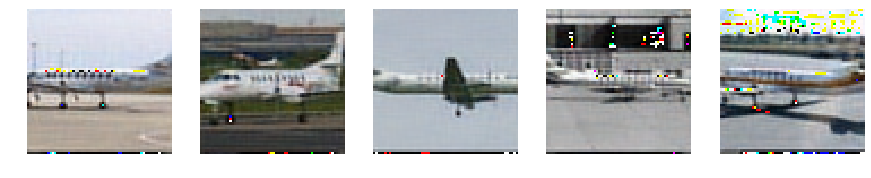

Epoch 31 /50 - loss = 65.59001159667969
Epoch 32 /50 - loss = 57.38388687133789
Epoch 33 /50 - loss = 53.40063537597656
Epoch 34 /50 - loss = 65.58479248046875
Epoch 35 /50 - loss = 50.56103332519531
Epoch 36 /50 - loss = 48.41164306640625


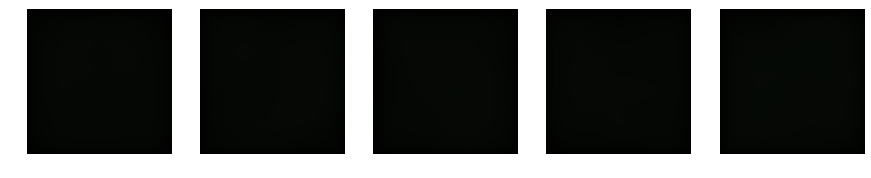

Epoch 1 /50 - loss = 18827.562604166666
Epoch 2 /50 - loss = 7159.315182291667
Epoch 3 /50 - loss = 3926.3837532552084
Epoch 4 /50 - loss = 1962.239148763021
Epoch 5 /50 - loss = 1352.2721549479168
Epoch 6 /50 - loss = 1241.2257682291668
Epoch 7 /50 - loss = 853.0950252278645
Epoch 8 /50 - loss = 575.0280733235677
Epoch 9 /50 - loss = 436.8491149902344
Epoch 10 /50 - loss = 356.13498657226563


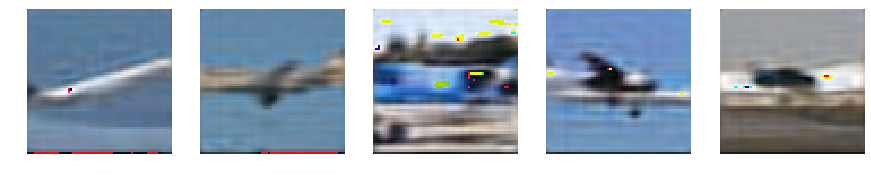

Epoch 11 /50 - loss = 290.33216796875
Epoch 12 /50 - loss = 242.98104370117187
Epoch 13 /50 - loss = 211.79960957845051
Epoch 14 /50 - loss = 183.16142883300782
Epoch 15 /50 - loss = 164.0840419514974
Epoch 16 /50 - loss = 147.6730928548177
Epoch 17 /50 - loss = 135.49259562174478
Epoch 18 /50 - loss = 125.79233642578124
Epoch 19 /50 - loss = 118.93856719970704
Epoch 20 /50 - loss = 111.62888834635417


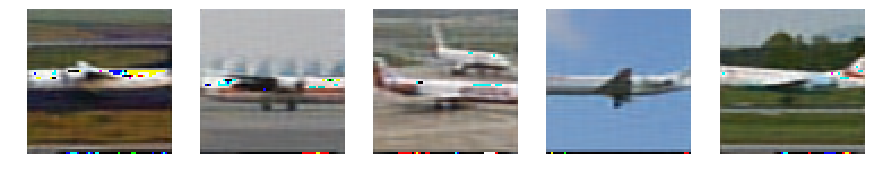

Epoch 21 /50 - loss = 107.03931966145834
Epoch 22 /50 - loss = 98.07106475830078
Epoch 23 /50 - loss = 98.20544118245442
Epoch 24 /50 - loss = 88.45766001383464
Epoch 25 /50 - loss = 86.98146402994792
Epoch 26 /50 - loss = 84.29697967529297
Epoch 27 /50 - loss = 78.61835174560547
Epoch 28 /50 - loss = 76.56934214274088
Epoch 29 /50 - loss = 74.11275909423829
Epoch 30 /50 - loss = 73.51747446695964


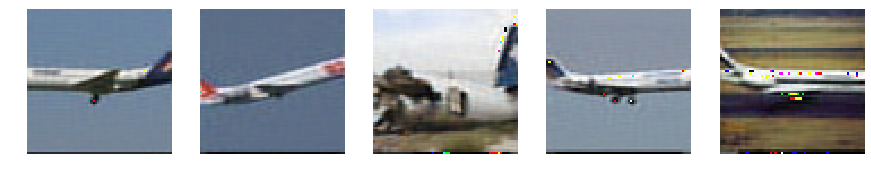

Epoch 31 /50 - loss = 69.03275217692057
Epoch 32 /50 - loss = 68.102587890625
Epoch 33 /50 - loss = 64.8691884358724
Epoch 34 /50 - loss = 64.62047770182292
Epoch 35 /50 - loss = 61.86026601155599
Epoch 36 /50 - loss = 59.89795099894206
Epoch 37 /50 - loss = 60.76210062662761
Epoch 38 /50 - loss = 57.86289220174154
Epoch 39 /50 - loss = 59.349944864908856
Epoch 40 /50 - loss = 55.17098251342773


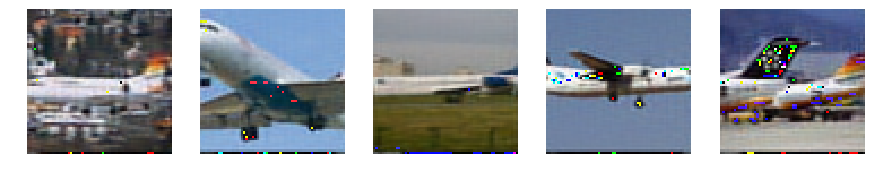

Epoch 41 /50 - loss = 55.007337239583336
Epoch 42 /50 - loss = 55.79828770955404
Epoch 43 /50 - loss = 53.01024424235026
Epoch 44 /50 - loss = 52.22402201334636
Epoch 45 /50 - loss = 53.2841731262207
Epoch 46 /50 - loss = 52.63357579549154
Epoch 47 /50 - loss = 52.59541809082031
Epoch 48 /50 - loss = 49.11386825561524


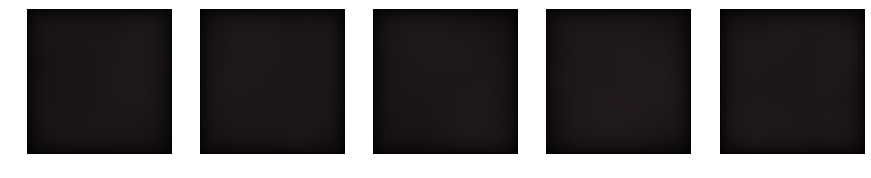

Epoch 1 /50 - loss = 18393.4275
Epoch 2 /50 - loss = 5030.9405078125
Epoch 3 /50 - loss = 3413.04724609375
Epoch 4 /50 - loss = 1760.873525390625
Epoch 5 /50 - loss = 1214.1081298828126
Epoch 6 /50 - loss = 848.9967602539062
Epoch 7 /50 - loss = 627.9862060546875
Epoch 8 /50 - loss = 447.7196337890625
Epoch 9 /50 - loss = 298.79639404296876
Epoch 10 /50 - loss = 254.01596557617188


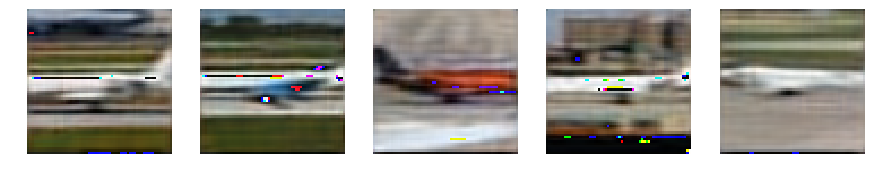

Epoch 11 /50 - loss = 225.96219787597656
Epoch 12 /50 - loss = 180.55804321289062
Epoch 13 /50 - loss = 151.91860473632812
Epoch 14 /50 - loss = 136.15502960205077
Epoch 15 /50 - loss = 133.89923583984375
Epoch 16 /50 - loss = 111.42006896972656
Epoch 17 /50 - loss = 104.65568786621094
Epoch 18 /50 - loss = 96.43524169921875
Epoch 19 /50 - loss = 92.44543212890625
Epoch 20 /50 - loss = 89.75942749023437


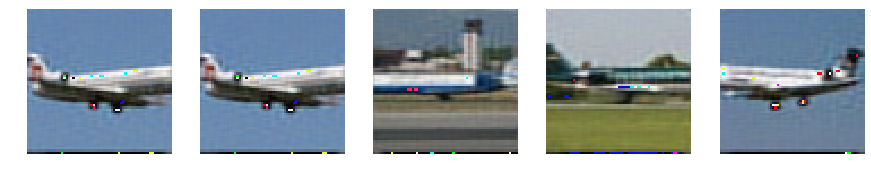

Epoch 21 /50 - loss = 81.27424224853516
Epoch 22 /50 - loss = 80.04107513427735
Epoch 23 /50 - loss = 74.49354034423828
Epoch 24 /50 - loss = 71.62060913085938
Epoch 25 /50 - loss = 70.38443634033203
Epoch 26 /50 - loss = 68.12835357666016
Epoch 27 /50 - loss = 68.91784637451173
Epoch 28 /50 - loss = 63.33341979980469
Epoch 29 /50 - loss = 74.58920928955078
Epoch 30 /50 - loss = 63.14836517333984


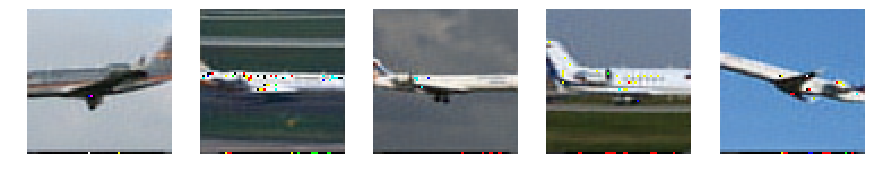

Epoch 31 /50 - loss = 56.833664398193356
Epoch 32 /50 - loss = 56.70061935424805
Epoch 33 /50 - loss = 58.507173767089846
Epoch 34 /50 - loss = 59.59793151855469
Epoch 35 /50 - loss = 51.18751953125
Epoch 36 /50 - loss = 51.01418273925781
Epoch 37 /50 - loss = 55.73672180175781
Epoch 38 /50 - loss = 50.11350921630859
Epoch 39 /50 - loss = 47.27147903442383


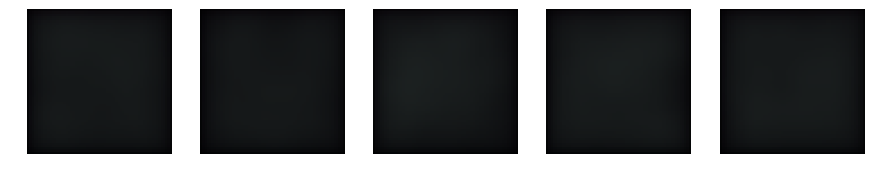

Epoch 1 /50 - loss = 18935.87703125
Epoch 2 /50 - loss = 5224.8841796875
Epoch 3 /50 - loss = 3018.8216015625
Epoch 4 /50 - loss = 1878.90490234375
Epoch 5 /50 - loss = 1224.604970703125
Epoch 6 /50 - loss = 995.9248681640624
Epoch 7 /50 - loss = 712.5977392578125
Epoch 8 /50 - loss = 492.458388671875
Epoch 9 /50 - loss = 346.22591674804687
Epoch 10 /50 - loss = 278.2234948730469


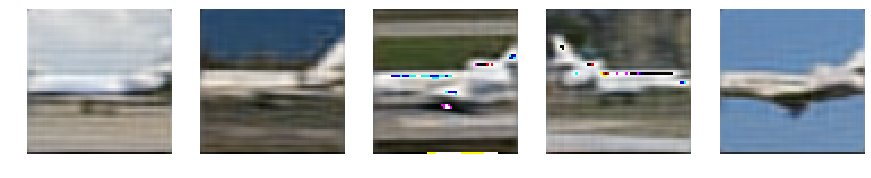

Epoch 11 /50 - loss = 229.83423828125
Epoch 12 /50 - loss = 186.03300903320311
Epoch 13 /50 - loss = 163.49569702148438
Epoch 14 /50 - loss = 144.1684423828125
Epoch 15 /50 - loss = 118.7248748779297
Epoch 16 /50 - loss = 118.74612182617187
Epoch 17 /50 - loss = 99.81044555664063
Epoch 18 /50 - loss = 101.82442565917968
Epoch 19 /50 - loss = 89.75282257080079
Epoch 20 /50 - loss = 83.33354034423829


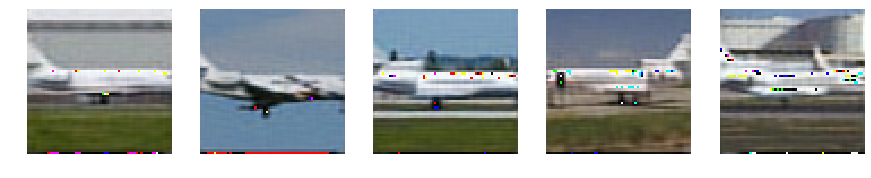

Epoch 21 /50 - loss = 78.55218017578125
Epoch 22 /50 - loss = 79.7610092163086
Epoch 23 /50 - loss = 74.39706634521484
Epoch 24 /50 - loss = 72.95556701660156
Epoch 25 /50 - loss = 70.1629556274414
Epoch 26 /50 - loss = 65.12078765869141
Epoch 27 /50 - loss = 64.20841064453126
Epoch 28 /50 - loss = 66.22136291503907
Epoch 29 /50 - loss = 60.87529266357422
Epoch 30 /50 - loss = 62.58732452392578


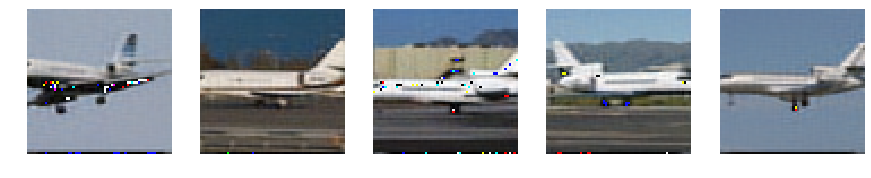

Epoch 31 /50 - loss = 56.74364105224609
Epoch 32 /50 - loss = 54.453915710449216
Epoch 33 /50 - loss = 52.75638153076172
Epoch 34 /50 - loss = 57.128249969482425
Epoch 35 /50 - loss = 53.14455123901367
Epoch 36 /50 - loss = 51.887584075927734
Epoch 37 /50 - loss = 47.15895233154297


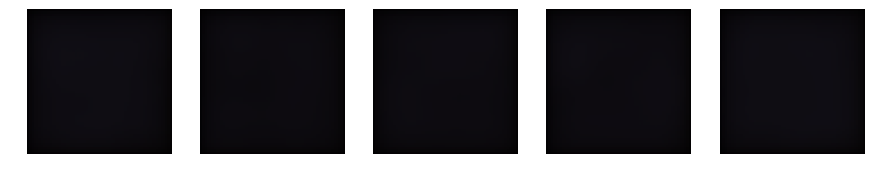

Epoch 1 /50 - loss = 26809.348671875
Epoch 2 /50 - loss = 13694.143671875
Epoch 3 /50 - loss = 5152.638994140625
Epoch 4 /50 - loss = 2239.800458984375
Epoch 5 /50 - loss = 1388.9164697265626
Epoch 6 /50 - loss = 1254.65091796875
Epoch 7 /50 - loss = 825.6451782226562
Epoch 8 /50 - loss = 563.9726098632813
Epoch 9 /50 - loss = 371.5539599609375
Epoch 10 /50 - loss = 296.62583740234373


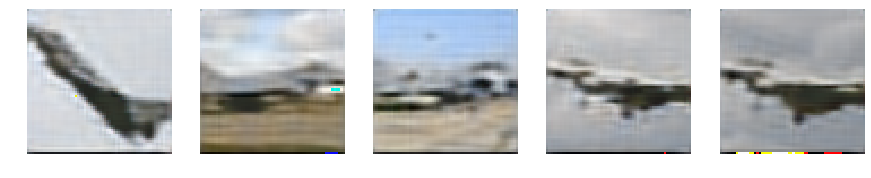

Epoch 11 /50 - loss = 249.61901245117187
Epoch 12 /50 - loss = 207.8116796875
Epoch 13 /50 - loss = 222.841708984375
Epoch 14 /50 - loss = 160.30002319335938
Epoch 15 /50 - loss = 138.31744018554687
Epoch 16 /50 - loss = 133.42623779296875
Epoch 17 /50 - loss = 134.34256103515625
Epoch 18 /50 - loss = 105.67891632080078
Epoch 19 /50 - loss = 102.1460498046875
Epoch 20 /50 - loss = 94.42288421630859


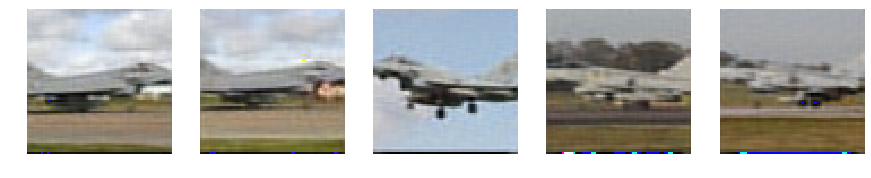

Epoch 21 /50 - loss = 83.35042114257813
Epoch 22 /50 - loss = 77.2458999633789
Epoch 23 /50 - loss = 71.90160888671875
Epoch 24 /50 - loss = 72.1751904296875
Epoch 25 /50 - loss = 67.44415466308594
Epoch 26 /50 - loss = 61.608148193359376
Epoch 27 /50 - loss = 60.21867004394531
Epoch 28 /50 - loss = 61.65135101318359
Epoch 29 /50 - loss = 57.82197540283203
Epoch 30 /50 - loss = 52.49678237915039


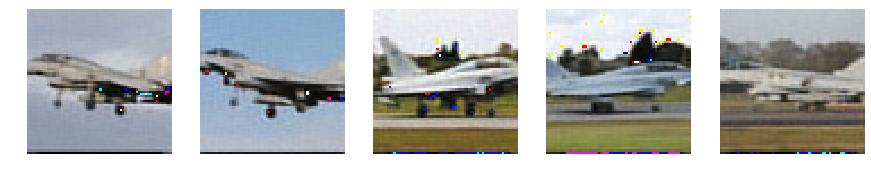

Epoch 31 /50 - loss = 55.31465637207031
Epoch 32 /50 - loss = 49.87847839355469


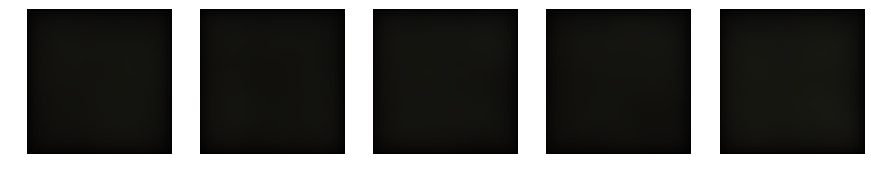

Epoch 1 /50 - loss = 19138.88890625
Epoch 2 /50 - loss = 5178.463046875
Epoch 3 /50 - loss = 3397.565087890625
Epoch 4 /50 - loss = 2044.05048828125
Epoch 5 /50 - loss = 1455.202685546875
Epoch 6 /50 - loss = 1264.435498046875
Epoch 7 /50 - loss = 800.48763671875
Epoch 8 /50 - loss = 579.2602001953124
Epoch 9 /50 - loss = 379.6801220703125
Epoch 10 /50 - loss = 316.9355859375


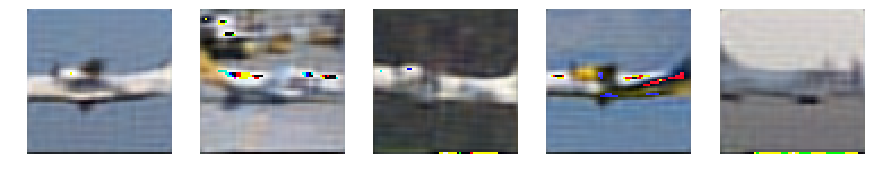

Epoch 11 /50 - loss = 267.7365417480469
Epoch 12 /50 - loss = 224.96107360839844
Epoch 13 /50 - loss = 198.3384002685547
Epoch 14 /50 - loss = 176.76805786132812
Epoch 15 /50 - loss = 155.192353515625
Epoch 16 /50 - loss = 142.1090167236328
Epoch 17 /50 - loss = 150.28309326171876
Epoch 18 /50 - loss = 120.78646606445312
Epoch 19 /50 - loss = 111.25656188964844
Epoch 20 /50 - loss = 101.47630798339844


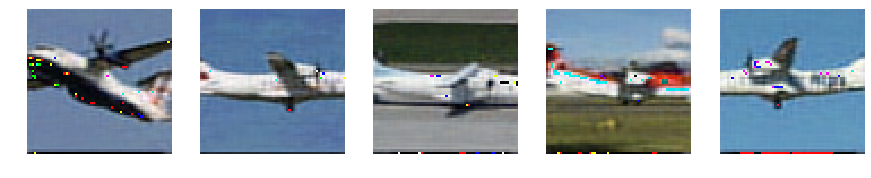

Epoch 21 /50 - loss = 93.87653381347656
Epoch 22 /50 - loss = 89.09698715209962
Epoch 23 /50 - loss = 84.22113342285157
Epoch 24 /50 - loss = 81.42510314941406
Epoch 25 /50 - loss = 76.49850524902344
Epoch 26 /50 - loss = 74.89126770019531
Epoch 27 /50 - loss = 70.49783721923828
Epoch 28 /50 - loss = 66.32207916259766
Epoch 29 /50 - loss = 69.91789245605469
Epoch 30 /50 - loss = 70.2929541015625


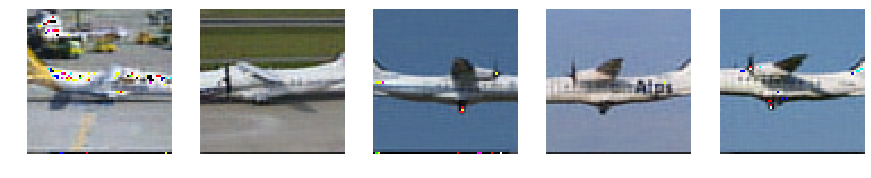

Epoch 31 /50 - loss = 59.396147918701175
Epoch 32 /50 - loss = 60.1297004699707
Epoch 33 /50 - loss = 56.79651412963867
Epoch 34 /50 - loss = 55.43091735839844
Epoch 35 /50 - loss = 56.33404647827148
Epoch 36 /50 - loss = 53.013417358398435
Epoch 37 /50 - loss = 55.06710144042969
Epoch 38 /50 - loss = 58.590349731445315
Epoch 39 /50 - loss = 49.144118041992186


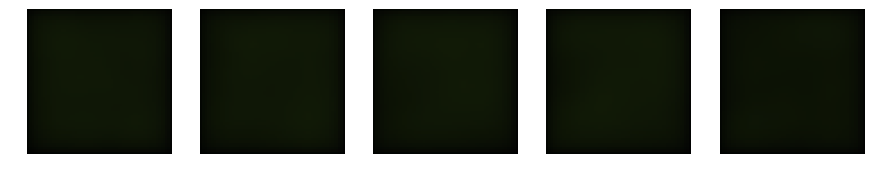

Epoch 1 /50 - loss = 19704.12140625
Epoch 2 /50 - loss = 7438.5148046875
Epoch 3 /50 - loss = 2944.66814453125
Epoch 4 /50 - loss = 1612.8864453125
Epoch 5 /50 - loss = 1151.939375
Epoch 6 /50 - loss = 983.319443359375
Epoch 7 /50 - loss = 761.2110717773437
Epoch 8 /50 - loss = 448.85554931640627
Epoch 9 /50 - loss = 295.4620349121094
Epoch 10 /50 - loss = 227.82774047851564


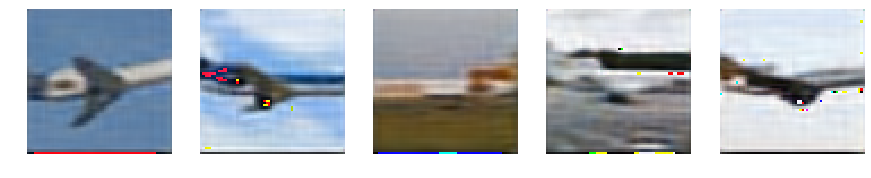

Epoch 11 /50 - loss = 238.71654602050782
Epoch 12 /50 - loss = 187.5968096923828
Epoch 13 /50 - loss = 135.15247589111328
Epoch 14 /50 - loss = 122.83571502685547
Epoch 15 /50 - loss = 109.47004821777344
Epoch 16 /50 - loss = 93.03728057861328
Epoch 17 /50 - loss = 85.07657897949218
Epoch 18 /50 - loss = 80.77768188476563
Epoch 19 /50 - loss = 79.31662414550782
Epoch 20 /50 - loss = 102.97713134765625


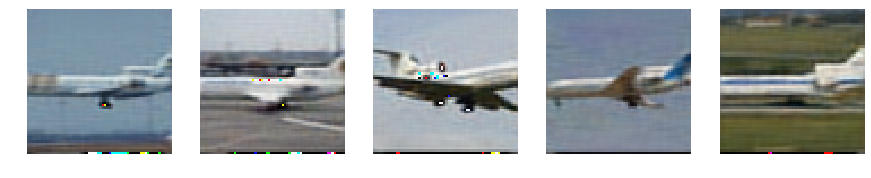

Epoch 21 /50 - loss = 71.02080291748047
Epoch 22 /50 - loss = 64.92234985351563
Epoch 23 /50 - loss = 57.53706176757812
Epoch 24 /50 - loss = 59.198015747070315
Epoch 25 /50 - loss = 57.595724487304686
Epoch 26 /50 - loss = 52.98392044067383
Epoch 27 /50 - loss = 50.019430236816405
Epoch 28 /50 - loss = 47.37628540039063


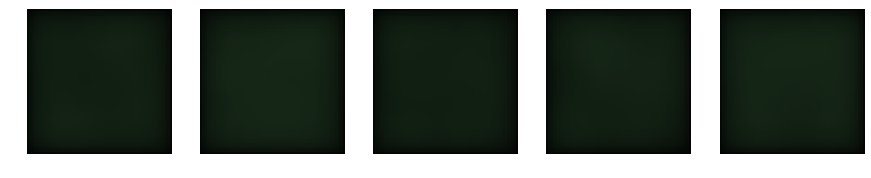

Epoch 1 /50 - loss = 26491.694765625
Epoch 2 /50 - loss = 7216.2822265625
Epoch 3 /50 - loss = 3306.31212890625
Epoch 4 /50 - loss = 1636.70076171875
Epoch 5 /50 - loss = 1110.8038671875
Epoch 6 /50 - loss = 941.45404296875
Epoch 7 /50 - loss = 662.8140673828125
Epoch 8 /50 - loss = 471.78587890625
Epoch 9 /50 - loss = 319.20636962890626
Epoch 10 /50 - loss = 252.93242065429686


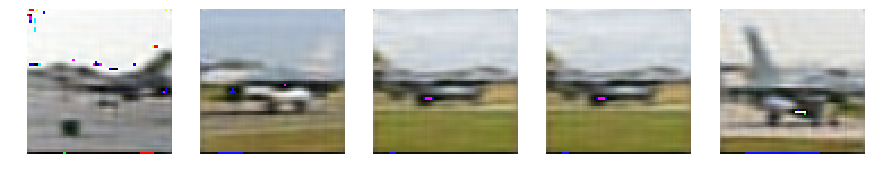

Epoch 11 /50 - loss = 219.4819177246094
Epoch 12 /50 - loss = 178.942158203125
Epoch 13 /50 - loss = 156.09664489746095
Epoch 14 /50 - loss = 131.49629821777344
Epoch 15 /50 - loss = 122.4021826171875
Epoch 16 /50 - loss = 109.00200866699218
Epoch 17 /50 - loss = 105.36838989257812
Epoch 18 /50 - loss = 93.32392364501953
Epoch 19 /50 - loss = 94.61716735839843
Epoch 20 /50 - loss = 78.97047729492188


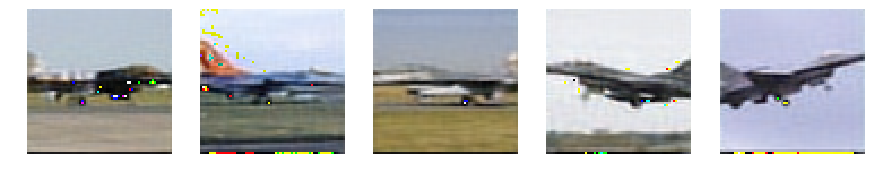

Epoch 21 /50 - loss = 74.6403887939453
Epoch 22 /50 - loss = 68.79344970703124
Epoch 23 /50 - loss = 67.29189880371094
Epoch 24 /50 - loss = 61.60183288574219
Epoch 25 /50 - loss = 57.21854949951172
Epoch 26 /50 - loss = 54.7641926574707
Epoch 27 /50 - loss = 58.73379379272461
Epoch 28 /50 - loss = 56.35157348632813
Epoch 29 /50 - loss = 49.325427551269534


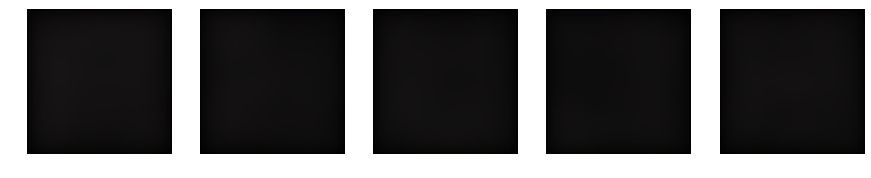

Epoch 1 /50 - loss = 17241.2328515625
Epoch 2 /50 - loss = 5017.223984375
Epoch 3 /50 - loss = 3020.46205078125
Epoch 4 /50 - loss = 1878.65072265625
Epoch 5 /50 - loss = 1395.1899951171874
Epoch 6 /50 - loss = 1179.66548828125
Epoch 7 /50 - loss = 902.0658666992188
Epoch 8 /50 - loss = 687.8031372070312
Epoch 9 /50 - loss = 459.50243774414065
Epoch 10 /50 - loss = 360.9572509765625


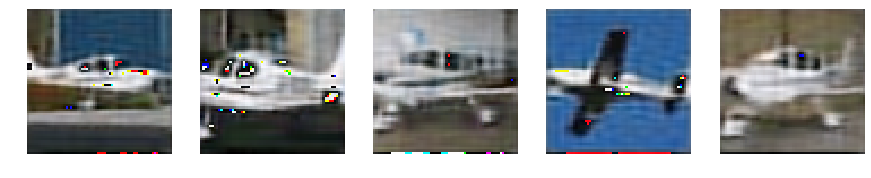

Epoch 11 /50 - loss = 308.51845458984377
Epoch 12 /50 - loss = 281.25372924804685
Epoch 13 /50 - loss = 213.13132873535156
Epoch 14 /50 - loss = 191.8886560058594
Epoch 15 /50 - loss = 161.56265625
Epoch 16 /50 - loss = 144.95421142578124
Epoch 17 /50 - loss = 137.2731884765625
Epoch 18 /50 - loss = 122.36688781738282
Epoch 19 /50 - loss = 114.3947543334961
Epoch 20 /50 - loss = 102.15201873779297


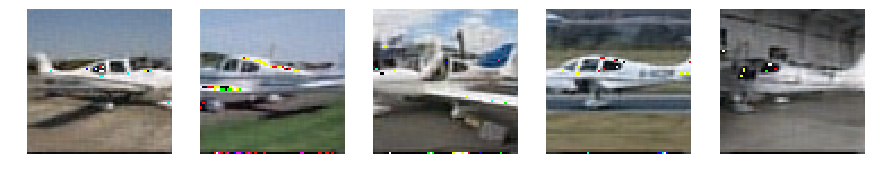

Epoch 21 /50 - loss = 100.54182922363282
Epoch 22 /50 - loss = 94.63213348388672
Epoch 23 /50 - loss = 93.5617462158203
Epoch 24 /50 - loss = 86.3605810546875
Epoch 25 /50 - loss = 81.85765502929688
Epoch 26 /50 - loss = 73.81660919189453
Epoch 27 /50 - loss = 74.21777465820313
Epoch 28 /50 - loss = 82.56291488647462
Epoch 29 /50 - loss = 72.19965866088867
Epoch 30 /50 - loss = 67.55592254638673


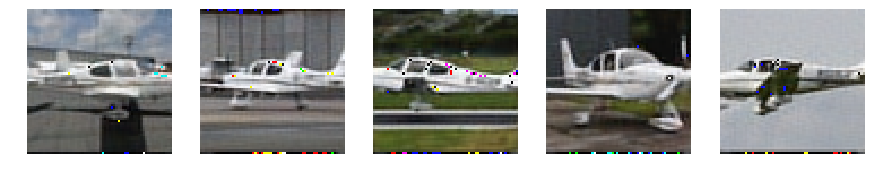

Epoch 31 /50 - loss = 62.87900314331055
Epoch 32 /50 - loss = 58.94095825195313
Epoch 33 /50 - loss = 65.03725143432617
Epoch 34 /50 - loss = 61.98510009765625
Epoch 35 /50 - loss = 67.54460327148438
Epoch 36 /50 - loss = 56.75379364013672
Epoch 37 /50 - loss = 58.434498901367185
Epoch 38 /50 - loss = 50.2194075012207
Epoch 39 /50 - loss = 50.655396423339845
Epoch 40 /50 - loss = 53.66471374511719


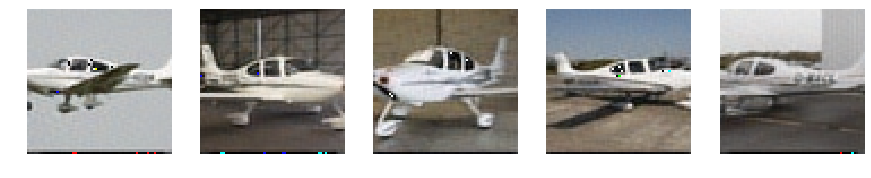

Epoch 41 /50 - loss = 49.29330169677734


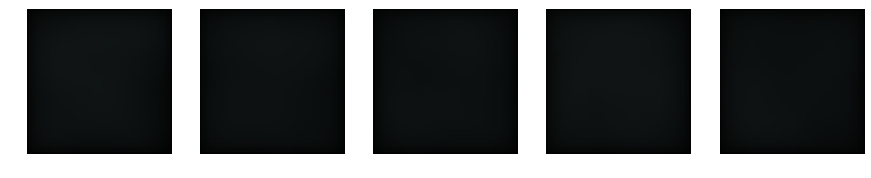

Epoch 1 /50 - loss = 17937.9361328125
Epoch 2 /50 - loss = 5623.5698828125
Epoch 3 /50 - loss = 3578.28462890625
Epoch 4 /50 - loss = 1926.13169921875
Epoch 5 /50 - loss = 1358.903125
Epoch 6 /50 - loss = 1172.3239453125
Epoch 7 /50 - loss = 943.9936450195313
Epoch 8 /50 - loss = 725.7049072265625
Epoch 9 /50 - loss = 463.2349377441406
Epoch 10 /50 - loss = 356.9333764648438


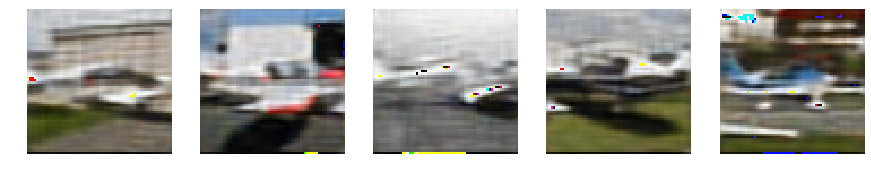

Epoch 11 /50 - loss = 287.66977783203123
Epoch 12 /50 - loss = 242.76152709960937
Epoch 13 /50 - loss = 204.68173950195313
Epoch 14 /50 - loss = 183.2612145996094
Epoch 15 /50 - loss = 159.11533203125
Epoch 16 /50 - loss = 149.80422912597658
Epoch 17 /50 - loss = 134.47131225585937
Epoch 18 /50 - loss = 125.59966796875
Epoch 19 /50 - loss = 113.2063623046875
Epoch 20 /50 - loss = 110.6783447265625


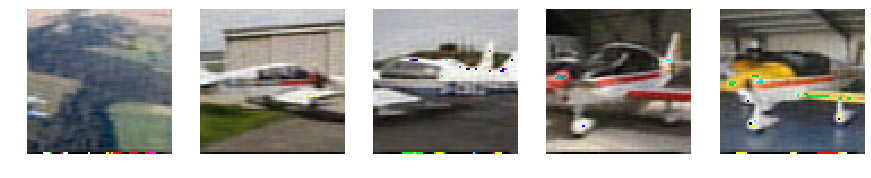

Epoch 21 /50 - loss = 100.56441162109375
Epoch 22 /50 - loss = 94.06063903808594
Epoch 23 /50 - loss = 93.7881072998047
Epoch 24 /50 - loss = 84.98234375
Epoch 25 /50 - loss = 85.87986877441406
Epoch 26 /50 - loss = 81.0748519897461
Epoch 27 /50 - loss = 74.49555725097656
Epoch 28 /50 - loss = 74.36701263427734
Epoch 29 /50 - loss = 81.77186706542969
Epoch 30 /50 - loss = 69.69747314453124


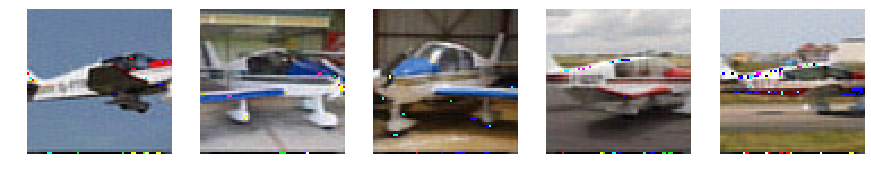

Epoch 31 /50 - loss = 68.20388610839844
Epoch 32 /50 - loss = 73.52835174560546
Epoch 33 /50 - loss = 63.02165802001953
Epoch 34 /50 - loss = 65.11716125488282
Epoch 35 /50 - loss = 58.7739323425293
Epoch 36 /50 - loss = 57.00709548950195
Epoch 37 /50 - loss = 54.2633772277832
Epoch 38 /50 - loss = 60.70989700317383
Epoch 39 /50 - loss = 59.42822784423828
Epoch 40 /50 - loss = 51.99111114501953


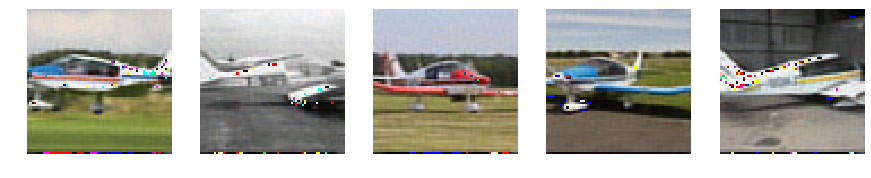

Epoch 41 /50 - loss = 53.90893920898438
Epoch 42 /50 - loss = 50.08501022338867
Epoch 43 /50 - loss = 48.175482482910155


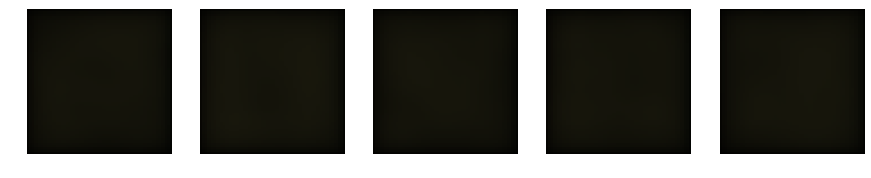

Epoch 1 /50 - loss = 19444.0021875
Epoch 2 /50 - loss = 5272.401884765625
Epoch 3 /50 - loss = 2576.49578125
Epoch 4 /50 - loss = 1529.912275390625
Epoch 5 /50 - loss = 1040.73634765625
Epoch 6 /50 - loss = 854.4053833007813
Epoch 7 /50 - loss = 577.3982666015625
Epoch 8 /50 - loss = 427.4657934570312
Epoch 9 /50 - loss = 288.9064001464844
Epoch 10 /50 - loss = 245.24949951171874


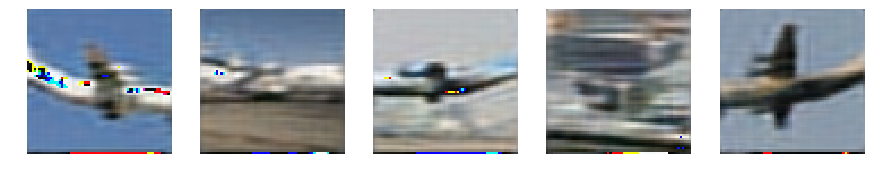

Epoch 11 /50 - loss = 193.43082580566406
Epoch 12 /50 - loss = 156.60064819335938
Epoch 13 /50 - loss = 135.8184033203125
Epoch 14 /50 - loss = 117.48010955810547
Epoch 15 /50 - loss = 130.34315795898436
Epoch 16 /50 - loss = 95.26888732910156
Epoch 17 /50 - loss = 88.62805236816406
Epoch 18 /50 - loss = 79.69014465332032
Epoch 19 /50 - loss = 82.48733276367187
Epoch 20 /50 - loss = 72.37604537963867


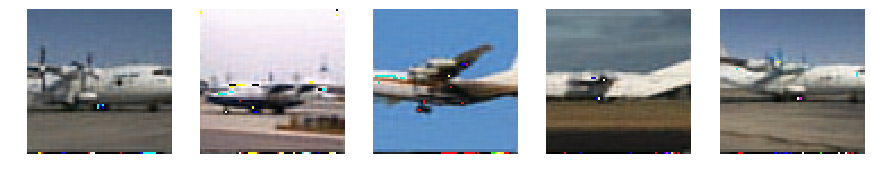

Epoch 21 /50 - loss = 65.39482040405274
Epoch 22 /50 - loss = 63.11026428222656
Epoch 23 /50 - loss = 57.0520590209961
Epoch 24 /50 - loss = 55.198718566894534
Epoch 25 /50 - loss = 52.52292282104492
Epoch 26 /50 - loss = 49.703262939453126


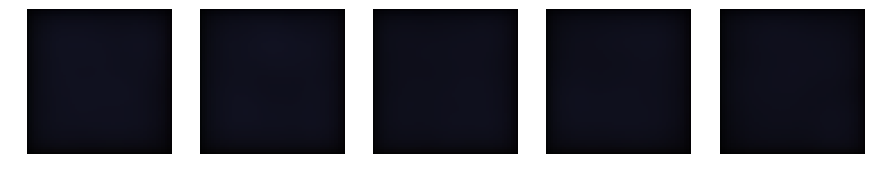

Epoch 1 /50 - loss = 17649.967109375
Epoch 2 /50 - loss = 4441.5362109375
Epoch 3 /50 - loss = 2531.82388671875
Epoch 4 /50 - loss = 1550.08037109375
Epoch 5 /50 - loss = 1170.9367041015626
Epoch 6 /50 - loss = 958.7675439453125
Epoch 7 /50 - loss = 604.9077587890625
Epoch 8 /50 - loss = 419.50312255859376
Epoch 9 /50 - loss = 283.418203125
Epoch 10 /50 - loss = 238.830234375


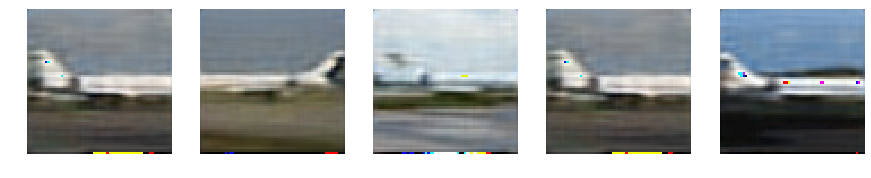

Epoch 11 /50 - loss = 211.13201416015625
Epoch 12 /50 - loss = 168.42732727050782
Epoch 13 /50 - loss = 154.32755493164063
Epoch 14 /50 - loss = 137.27358612060547
Epoch 15 /50 - loss = 125.00299438476563
Epoch 16 /50 - loss = 113.79386260986328
Epoch 17 /50 - loss = 107.06298217773437
Epoch 18 /50 - loss = 100.15232696533204
Epoch 19 /50 - loss = 100.71738342285157
Epoch 20 /50 - loss = 100.18511535644531


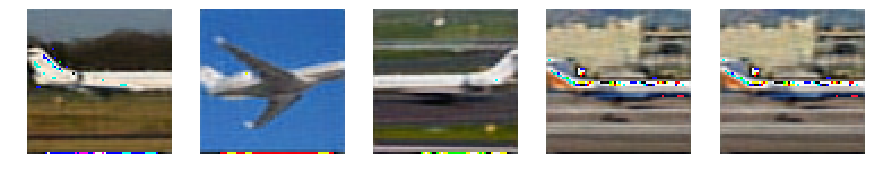

Epoch 21 /50 - loss = 96.82818786621094
Epoch 22 /50 - loss = 83.42478454589843
Epoch 23 /50 - loss = 80.0267936706543
Epoch 24 /50 - loss = 119.0383984375
Epoch 25 /50 - loss = 83.3560595703125
Epoch 26 /50 - loss = 71.02103240966797
Epoch 27 /50 - loss = 68.46915496826172
Epoch 28 /50 - loss = 63.76727951049805
Epoch 29 /50 - loss = 65.88972473144531
Epoch 30 /50 - loss = 60.76612060546875


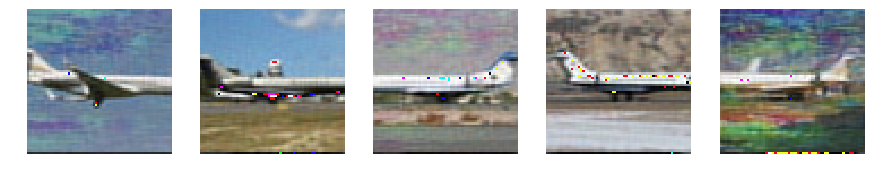

Epoch 31 /50 - loss = 60.276943359375
Epoch 32 /50 - loss = 59.51781433105469
Epoch 33 /50 - loss = 56.442122802734374
Epoch 34 /50 - loss = 58.2415739440918
Epoch 35 /50 - loss = 52.330463562011715
Epoch 36 /50 - loss = 54.3774462890625
Epoch 37 /50 - loss = 50.246593933105466
Epoch 38 /50 - loss = 51.322308959960935
Epoch 39 /50 - loss = 51.85332275390625
Epoch 40 /50 - loss = 54.4972900390625


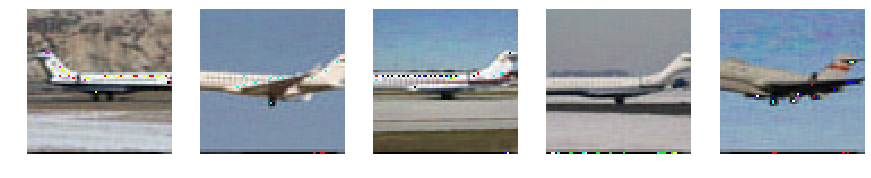

Epoch 41 /50 - loss = 46.858225708007815


In [18]:
for i in range(30):
    
    # TRAIN NETWORKS
    ep = 1; it = 50
    lr = 0.005
    ic = ic_list[i]
    if (ic == 100): bs = 32
    elif (ic < 300): bs = 64
    else: bs = 128
    
    # TRAINING DATA
    train = np.zeros((ic,ic))
    for j in range(ic): train[j,j] = 1
    zeros = np.zeros((ic,12288))
    
    for k in range(it):  
        
        # BEGIN DISCRIMINATOR COACHES GENERATOR
        annealer = LearningRateScheduler(lambda x: lr)
        h = gan[i].fit(train, zeros, epochs = ep, batch_size=bs, callbacks=[annealer], verbose=0)

        # DISPLAY GENERATOR LEARNING PROGRESS
        if k%10 == 0:
            plt.figure(figsize=(15,3))
            for j in range(5):
                xx = np.zeros((ic))
                xx[np.random.randint(ic)] = 1
                plt.subplot(1,5,j+1)
                img = generator[i].predict(xx.reshape((-1,ic)))[0].reshape((-1,64,64,3))
                img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
                plt.axis('off')
                plt.imshow(img)
            plt.show()  
        print('Epoch',(k+1),'/'+str(it)+' - loss =',h.history['loss'][-1] )
        # ADJUST LEARNING RATES

        ep *= 2
        if ep>=32: lr = 0.001
        if ep>256: ep = 256
            
        if h.history['loss'][-1] < 50: break

# Build Generator Class
Our Generative Network has now learned all the training images from our Discriminative Network. With its poor memory, we hope that it has learned to generalize somewhat. Now let's build a Generator Class that accepts any random 100 dimensional vector and outputs an image. Our class will return 70% of one "memorized" image mixed with 30% another. Since the images are stored in a convolutional network, we hope that it makes a generalized conceptual mixture (versus a pixel blend).

In [1]:
class PlaneGenerator:
    index = 0   
    def getPlane(self, ptype):
        ic = ic_list[ptype]
        xx = np.zeros((ic))
        xx[self.index] = 1
        xx[np.random.randint(ic)] = 0
        img = generator[ptype].predict(xx.reshape((-1,ic)))[0].reshape((64,64,3))
        self.index = (self.index+1)%ic
        return Image.fromarray( img.astype('uint8') ) 

# Examples of Generated Planes

NameError: name 'ic_list' is not defined

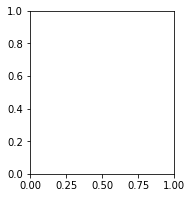

In [4]:
import matplotlib.pyplot as plt, zipfile 
# DISPLAY EXAMPLE PLANES
p = [PlaneGenerator() for i in range(30)]
for k in range(3):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = p[0].getPlane(0)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

# Submit to Kaggle
In this kernel we learned how to make an experimental GAN. Currently it scores around LB 100. We must be careful as we try to improve its score. If we give this GAN excellent memory and request a mixture of 99.9% one image and 0.1% another, then it can score LB 7 but then it is returning "altered versions" of images and violates the rules [here][1]

[1]: https://www.kaggle.com/c/generative-dog-images/discussion/98183

In [3]:
#NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')
i = 0
for ptype in image_count.keys() :
    for k in range(1, 11):
        img = p[i].getPlane(i)
        f = f"{ptype}\\{str(k)}.png"
        img.save(f,'PNG'); z.write(f); os.remove(f)
        #if k % 1000==0: print(k)
    i = i+1
z.close()

NameError: name 'zipfile' is not defined